# A Comprehensive Exploration of Covid-19 in Malaysia 🇲🇾
<i>Sidharrth Nagappan, Eugene Kan, Tan Zhi Hang, 2021</i>
<br>
<br>
<img src="covid-malaysia.jpeg" width="400px"/>
<br>
<br>

This notebook will conduct a comprehensive analysis of Covid-19 in Malaysia, while evaluating the performance of the nation in combatting the pandemic and putting this performance up against other countries in South East Asia. Covid-19 has taken the world by storm and we use open data to extract critical insights.

There are 3 parts to this notebook:

* Preprocessing
* Exploratory Data Analysis
* Modelling

**Do not run the notebook top down because several deep learning models will begin to train in a later stage**.

For detailed explanations for each question, please refer to the submitted report instead.

#### Importing the necessary libraries
Additional libraries:
* Tensorflow- for the LSTM model
* BorutaPy- for feature selection
* ARIMAX- hyperparameter tuning for ARIMA model
* ARIMA- ARIMA model

If you wish to run this notebook, you can create a virtual environment using the dependencies listed in `requirements.txt`.

In [133]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.feature_selection import SelectKBest,mutual_info_regression, RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split  
from sklearn.tree import DecisionTreeRegressor  
from sklearn.metrics import mean_squared_error,mean_absolute_error
warnings.filterwarnings('ignore')

#### Reading dataset files

Should you want to change the datasets or update to the latest date, place in folders from https://github.com/CITF-Malaysia/citf-public:
* cases
  * epidemic
* vaccination
  * vaccination
  
The following datasets will be used, all sourced from the Ministry of Health's Open Data:
1. cases_malaysia.csv
2. cases_state.csv
3. clusters.csv
4. deaths_malaysia.csv
5. deaths_state.csv
6. hospital.csv
7. icu.csv
8. pkrc.csv
9. tests_malaysia.csv
10. tests_state.csv

All datasets from MoH and CITF are from 9 October 2021. 

Additional Datasets:
1. Malaysian Department of Statistics Mean Income Per State Dataset
2. World Covid-19 dataset

In [134]:
cases_malaysia = pd.read_csv('./cases/epidemic/cases_malaysia.csv')
cases_state = pd.read_csv('./cases/epidemic/cases_state.csv')
clusters = pd.read_csv('./cases/epidemic/clusters.csv')
deaths_malaysia = pd.read_csv('./cases/epidemic/deaths_malaysia.csv')
deaths_state = pd.read_csv('./cases/epidemic/deaths_state.csv')
hospital = pd.read_csv('./cases/epidemic/hospital.csv')
icu = pd.read_csv('./cases/epidemic/icu.csv')
pkrc = pd.read_csv('./cases/epidemic/pkrc.csv')
tests_malaysia = pd.read_csv('./cases/epidemic/tests_malaysia.csv')
tests_state = pd.read_csv('./cases/epidemic/tests_state.csv') 
vax_malaysia = pd.read_csv('./vaccination/vaccination/vax_malaysia.csv') 
vax_state = pd.read_csv('./vaccination/vaccination/vax_state.csv') 
vaxreg_malaysia = pd.read_csv('./vaccination/registration/vaxreg_malaysia.csv') 
vaxreg_state = pd.read_csv('./vaccination/registration/vaxreg_state.csv') 
population = pd.read_csv('./vaccination/static/population.csv')
checkins = pd.read_csv('./cases/mysejahtera/checkin_malaysia.csv')
income = pd.read_csv('./vaccination/static/income.csv')
aefi = pd.read_csv('./cases/vaccination/aefi.csv')
trace_malaysia = pd.read_csv('./cases/mysejahtera/trace_malaysia.csv')

## Pre-processing
#### You can collapse this section, as there are many cells

1. Get statistical description of the data
2. Restructure dataset format by melting/pivot table
3. Deal with missing values and outliers (missing values will be dropped and outliers will be checked on case-by-case basis)

#### Conditional Handling of Outliers
Outliers are handled on a case-by-case basis because many outliers are usually meaningful, especially in the case of Covid statistics. 

#### Handling of missing values
Covid statistics are critical and replacing by the average or median of the statistic can be drastic. Since most missing values are attributed to the data not existing at that point in time (e.g. testing only started in Malaysia in January 2021), we choose to fill missing values with 0. This accounts for 2 possibilities:
1. The statistic is not available at that point in time.
2. The statistic is available but is not available for that particular case.

In [136]:
before_pp_cases_malaysia = cases_malaysia.copy()
before_pp_cases_state = cases_state.copy()
before_pp_clusters = clusters.copy()
before_pp_deaths_malaysia = deaths_malaysia.copy()
before_pp_deaths_state = deaths_state.copy()
before_pp_hospital = hospital.copy()
before_pp_icu = icu.copy()
before_pp_pkrc = pkrc.copy()
before_pp_tests_malaysia = tests_malaysia.copy()
before_pp_tests_state = tests_state.copy()
before_pp_vax_malaysia = vax_malaysia.copy()
before_pp_vax_state = vax_state.copy()
before_pp_vaxreg_malaysia = vaxreg_malaysia.copy()
before_pp_vaxreg_state = vaxreg_state.copy()
before_pp_population = population.copy()
before_pp_checkins = checkins.copy()
before_pp_income = income.copy()

### Cases Malaysia

In [366]:
cases_malaysia.describe()

,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_pvax,cases_fvax,cases_child,cases_adolescent,cases_adult,cases_elderly
count,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000
mean,3737.533654,7.972756,3501.137821,43232.615385,761.966346,604.892628,576.700321,495.581731,257.543269,2557.698718,298.129808
std,5866.620065,8.818714,5765.578012,70236.242819,848.866318,1586.970111,1672.717839,901.991743,449.434742,3924.621452,479.396213
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37.000000,3.000000,33.750000,842.500000,8.000000,0.000000,0.000000,1.000000,1.000000,23.000000,2.000000
50%,1173.000000,5.000000,1015.500000,12649.000000,535.500000,0.000000,0.000000,89.000000,52.000000,883.000000,57.500000
75%,4229.250000,10.000000,3934.500000,47940.250000,1272.250000,43.250000,19.750000,423.000000,311.250000,3058.750000,378.000000
max,24599.000000,72.000000,24855.000000,263929.000000,3394.000000,7290.000000,8383.000000,5766.000000,1840.000000,16440.000000,1941.000000


In [138]:
cases_malaysia.isna().sum()

date                         0
cases_new                    0
cases_import                 0
cases_recovered              0
cases_active                 0
cases_cluster                1
cases_pvax                   1
cases_fvax                   1
cases_child                  1
cases_adolescent             1
cases_adult                  1
cases_elderly                1
cluster_import             342
cluster_religious          342
cluster_community          342
cluster_highRisk           342
cluster_education          342
cluster_detentionCentre    342
cluster_workplace          342
dtype: int64

In [139]:
cases_malaysia.drop_duplicates(inplace=True)

In [140]:
# cluster columns are irrelevant, remove them
cases_malaysia.drop(columns=['cluster_import', 'cluster_religious', 'cluster_community', 'cluster_highRisk', 'cluster_education', 'cluster_detentionCentre', 'cluster_workplace'], inplace=True)
# other dates with a null value, just drop that row
cases_malaysia.fillna(0, inplace=True)
# cases_malaysia.head()

### Cases State

In [141]:
# cases_state

In [142]:
cases_state.isna().sum()

date                 0
state                0
cases_new            0
cases_import         0
cases_recovered      0
cases_active         0
cases_cluster       16
cases_pvax          16
cases_fvax          16
cases_child         16
cases_adolescent    16
cases_adult         16
cases_elderly       16
dtype: int64

In [143]:
cases_state.drop_duplicates(inplace=True)

In [144]:
cases_state.fillna(0, inplace=True)

In [145]:
cases_state_pivoted = cases_state.pivot(index='date', columns='state', values='cases_new')
cases_state_pivoted.head()

state,Johor,Kedah,Kelantan,Melaka,Negeri Sembilan,Pahang,Perak,Perlis,Pulau Pinang,Sabah,Sarawak,Selangor,Terengganu,W.P. Kuala Lumpur,W.P. Labuan,W.P. Putrajaya
date,,,,,,,,,,,,,,,,
2020-01-25,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-29,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Clusters

In [368]:
clusters.describe()

,cases_new,cases_total,cases_active,tests,icu,deaths,recovered
count,5560.00000,5560.000000,5560.000000,5560.000000,5560.000000,5560.000000,5560.000000
mean,0.12536,88.358633,3.422662,369.224281,0.004317,0.336151,84.564029
std,2.06547,222.529715,18.152285,1220.266965,0.068253,1.439725,220.755831
min,0.00000,2.000000,0.000000,3.000000,0.000000,0.000000,0.000000
25%,0.00000,20.000000,0.000000,59.750000,0.000000,0.000000,18.000000
50%,0.00000,39.000000,0.000000,139.000000,0.000000,0.000000,36.000000
75%,0.00000,83.000000,0.000000,329.000000,0.000000,0.000000,79.000000
max,94.00000,7205.000000,575.000000,42100.000000,2.000000,37.000000,7204.000000


In [147]:
clusters.isna().sum()

cluster            0
state              0
district           0
date_announced     0
date_last_onset    0
category           0
status             0
cases_new          0
cases_total        0
cases_active       0
tests              0
icu                0
deaths             0
recovered          0
dtype: int64

In [148]:
clusters.drop_duplicates(inplace=True)

### Deaths Malaysia

In [369]:
deaths_malaysia.describe()

,deaths_new
count,572.000000
mean,47.666084
std,93.291694
min,0.000000
25%,1.000000
50%,4.000000
75%,47.500000
max,592.000000


In [150]:
 deaths_malaysia.isna().sum()

date              0
deaths_new        0
deaths_bid        0
deaths_new_dod    0
deaths_bid_dod    0
deaths_pvax       0
deaths_fvax       0
deaths_tat        0
dtype: int64

In [151]:
deaths_malaysia.drop_duplicates(inplace=True)

In [152]:
deaths_malaysia.drop(columns=['deaths_bid', 'deaths_new_dod', 'deaths_bid_dod', 'deaths_pvax', 'deaths_fvax', 'deaths_tat'], inplace=True)
# deaths_malaysia.head()

### Deaths State

In [370]:
deaths_state.describe()

,deaths_new,deaths_bid,deaths_new_dod,deaths_bid_dod,deaths_pvax,deaths_fvax,deaths_tat
count,9152.000000,9152.000000,9152.000000,9152.000000,9152.000000,9152.000000,9152.000000
mean,2.979130,0.600962,2.979130,0.600962,0.649913,0.266936,1.262566
std,11.814853,3.414483,11.453121,2.888121,3.550505,1.197422,5.590124
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,359.000000,84.000000,191.000000,63.000000,68.000000,17.000000,176.000000


In [154]:
deaths_state.isna().sum()

date              0
state             0
deaths_new        0
deaths_bid        0
deaths_new_dod    0
deaths_bid_dod    0
deaths_pvax       0
deaths_fvax       0
deaths_tat        0
dtype: int64

In [155]:
deaths_state.drop_duplicates(inplace=True)

In [156]:
deaths_state_pivoted = deaths_state.pivot(index='date', columns='state', values='deaths_new')
deaths_state_pivoted.head()

state,Johor,Kedah,Kelantan,Melaka,Negeri Sembilan,Pahang,Perak,Perlis,Pulau Pinang,Sabah,Sarawak,Selangor,Terengganu,W.P. Kuala Lumpur,W.P. Labuan,W.P. Putrajaya
date,,,,,,,,,,,,,,,,
2020-03-17,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2020-03-18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-03-19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-03-20,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2020-03-21,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0


### Hospital

In [371]:
hospital.describe()

,beds_covid,admitted_covid,discharged_covid,hosp_covid
count,8627.000000,8627.000000,8627.000000,8627.000000
mean,497.048221,43.017387,36.509911,242.849078
std,564.311176,81.596462,73.086471,429.792595
min,4.000000,0.000000,0.000000,0.000000
25%,132.000000,0.000000,0.000000,7.000000
50%,323.000000,8.000000,7.000000,76.000000
75%,690.000000,47.000000,38.000000,323.000000
max,4713.000000,748.000000,658.000000,4218.000000


In [158]:
hospital.isna().sum()

date                0
state               0
beds                0
beds_covid          0
beds_noncrit        0
admitted_pui        0
admitted_covid      0
admitted_total      0
discharged_pui      0
discharged_covid    0
discharged_total    0
hosp_covid          0
hosp_pui            0
hosp_noncovid       0
dtype: int64

In [159]:
hospital.drop_duplicates(inplace=True)

In [160]:
hospital.drop(columns=['beds', 'beds_noncrit', 'admitted_pui', 'admitted_total', 'discharged_pui', 'discharged_total','hosp_pui','hosp_noncovid'], inplace=True)
# hospital.head()

### ICU

In [372]:
icu.describe()

,beds_icu_covid,icu_covid,vent_covid
count,8647.00000,8647.000000,8647.000000
mean,46.97502,27.302070,14.828611
std,50.53694,53.264211,31.451688
min,0.00000,0.000000,0.000000
25%,12.00000,0.000000,0.000000
50%,30.00000,4.000000,2.000000
75%,62.00000,32.000000,16.000000
max,380.00000,532.000000,294.000000


In [162]:
icu.isna().sum()

date              0
state             0
beds_icu          0
beds_icu_rep      0
beds_icu_total    0
beds_icu_covid    0
vent              0
vent_port         0
icu_covid         0
icu_pui           0
icu_noncovid      0
vent_covid        0
vent_pui          0
vent_noncovid     0
vent_used         0
vent_port_used    0
dtype: int64

In [163]:
icu.drop_duplicates(inplace=True)

In [164]:
icu.drop(columns=['beds_icu', 'beds_icu_rep', 'beds_icu_total', 'vent', 'vent_port', 'icu_pui','icu_noncovid','vent_pui','vent_noncovid','vent_used','vent_port_used'], inplace=True)
# icu.head()

### PKRC

In [373]:
pkrc.describe()

,admitted_covid,discharge_covid,pkrc_covid
count,6575.000000,6575.000000,6575.000000
mean,90.448365,88.246540,666.149962
std,176.220913,175.957694,1091.217510
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,9.000000
50%,17.000000,17.000000,167.000000
75%,103.000000,94.000000,797.000000
max,2040.000000,2278.000000,6685.000000


In [166]:
pkrc.isna().sum()

date               0
state              0
beds               0
admitted_pui       0
admitted_covid     0
admitted_total     0
discharge_pui      0
discharge_covid    0
discharge_total    0
pkrc_covid         0
pkrc_pui           0
pkrc_noncovid      0
dtype: int64

In [167]:
pkrc.drop_duplicates(inplace=True)

In [168]:
pkrc.drop(columns=['beds', 'admitted_pui', 'admitted_total', 'discharge_pui', 'discharge_total', 'pkrc_pui','pkrc_noncovid'], inplace=True)
# pkrc.head()

### Test Malaysia

In [374]:
tests_malaysia.describe()

,total_testing
count,622.000000
mean,50363.678457
std,49835.765363
min,2.000000
25%,7755.000000
50%,32132.000000
75%,82123.000000
max,181238.000000


In [170]:
tests_malaysia.isna().sum()

date      0
rtk-ag    0
pcr       0
dtype: int64

In [171]:
tests_malaysia.drop_duplicates(inplace=True)

In [172]:
tests_malaysia['total_testing'] = tests_malaysia['rtk-ag'] + tests_malaysia['pcr']
# tests_malaysia 

In [173]:
tests_malaysia.drop(columns=['rtk-ag', 'pcr'], inplace=True)
# tests_malaysia.head()

### Tests State

In [375]:
tests_malaysia.describe()

,total_testing
count,622.000000
mean,50363.678457
std,49835.765363
min,2.000000
25%,7755.000000
50%,32132.000000
75%,82123.000000
max,181238.000000


In [175]:
tests_state.isna().sum()

date      0
state     0
rtk-ag    0
pcr       0
dtype: int64

In [176]:
tests_state.drop_duplicates(inplace=True)

In [177]:
tests_state['total_testing'] = tests_state['rtk-ag'] + tests_state['pcr']
# tests_state

In [178]:
tests_state.drop(columns=['rtk-ag', 'pcr'], inplace=True)
# tests_state.head()

### Vaccination Malaysia

In [376]:
vax_malaysia.describe()

,daily_partial,daily_full,daily,daily_full_child,cumul,daily_adults,cumul_full,percentage_vaccinated
count,228.000000,228.000000,228.000000,228.000000,2.280000e+02,228.000000,2.280000e+02,228.000000
mean,106638.535088,93015.833333,199654.368421,897.087719,5.670501e+06,92118.745614,5.670501e+06,0.173636
std,94160.902455,96904.517010,176527.231577,3770.655763,6.986658e+06,96665.911544,6.986658e+06,0.213938
min,60.000000,0.000000,60.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000
25%,20099.500000,9096.250000,28695.000000,0.000000,4.895705e+05,9096.250000,4.895705e+05,0.014991
50%,91920.000000,46677.000000,175955.000000,0.000000,1.549175e+06,46677.000000,1.549175e+06,0.047437
75%,168816.500000,161794.000000,332069.500000,37.500000,1.033058e+07,161489.000000,1.033058e+07,0.316332
max,373486.000000,360602.000000,579774.000000,29091.000000,2.120761e+07,359852.000000,2.120761e+07,0.649397


In [180]:
vax_malaysia.isna().sum()

date                   0
daily_partial          0
daily_full             0
daily                  0
daily_partial_child    0
daily_full_child       0
cumul_partial          0
cumul_full             0
cumul                  0
cumul_partial_child    0
cumul_full_child       0
pfizer1                0
pfizer2                0
sinovac1               0
sinovac2               0
astra1                 0
astra2                 0
cansino                0
pending                0
dtype: int64

In [181]:
vax_malaysia.drop_duplicates(inplace=True)
vax_malaysia_all_attributes = vax_malaysia.copy()

In [182]:
# total up first and second dose
vax_malaysia_all_attributes['pfizer'] = vax_malaysia_all_attributes['pfizer1'] + vax_malaysia_all_attributes['pfizer2']
vax_malaysia_all_attributes['astra'] = vax_malaysia_all_attributes['astra1'] + vax_malaysia_all_attributes['astra2']
vax_malaysia_all_attributes['sinovac'] = vax_malaysia_all_attributes['sinovac1'] + vax_malaysia_all_attributes['sinovac2']

In [183]:
vax_malaysia.drop(columns=['daily_partial_child','cumul_partial','cumul_full','cumul','cumul_partial_child','cumul_full_child','pfizer1','pfizer2','sinovac1','sinovac2','astra1','astra2','cansino','pending'], inplace=True)
vax_malaysia['cumul'] = vax_malaysia['daily_full'].cumsum()
vax_malaysia.head()

,date,daily_partial,daily_full,daily,daily_full_child,cumul
0,2021-02-24,60,0,60,0,0
1,2021-02-25,1146,0,1146,0,0
2,2021-02-26,4115,1,4116,0,1
3,2021-02-27,6723,1,6724,0,2
4,2021-02-28,6699,3,6702,0,5


### Vaccination State

In [377]:
vax_state.describe()

,daily_full
count,3648.000000
mean,5813.489583
std,10952.773742
min,0.000000
25%,62.750000
50%,1433.000000
75%,6661.750000
max,109475.000000


In [185]:
vax_state.isna().sum()

date                   0
state                  0
daily_partial          0
daily_full             0
daily                  0
daily_partial_child    0
daily_full_child       0
cumul_partial          0
cumul_full             0
cumul                  0
cumul_partial_child    0
cumul_full_child       0
pfizer1                0
pfizer2                0
sinovac1               0
sinovac2               0
astra1                 0
astra2                 0
cansino                0
pending                0
dtype: int64

In [186]:
vax_state.drop_duplicates(inplace=True)

In [187]:
# vax_state.drop(columns=['daily_partial_child', 'daily_full_child','cumul_partial','cumul_full','cumul','cumul_partial_child','cumul_full_child','pfizer1','pfizer2','sinovac1','sinovac2','astra1','astra2','cansino','pending'], inplace=True)
# vax_state.head()

### Vaccination Registration Malaysia

In [379]:
vaxreg_malaysia.describe()

,total
count,1.080000e+02
mean,2.162853e+07
std,2.731621e+06
min,1.619149e+07
25%,1.936197e+07
50%,2.233374e+07
75%,2.402710e+07
max,2.494261e+07


In [189]:
vaxreg_malaysia.isna().sum()

date        0
state       0
total       0
phase2      0
mysj        0
call        0
web         0
children    0
elderly     0
comorb      0
oku         0
dtype: int64

In [190]:
vaxreg_malaysia.drop_duplicates(inplace=True)

In [191]:
vaxreg_malaysia.drop(columns=['phase2', 'mysj','call','web','children','elderly','comorb','oku'], inplace=True)
# vaxreg_malaysia.head()

### Vaccination Registration State

In [380]:
vaxreg_state.describe()

,total
count,1.728000e+03
mean,1.351783e+06
std,1.219733e+06
min,5.617000e+04
25%,6.628232e+05
50%,1.047962e+06
75%,1.750252e+06
max,5.733051e+06


In [193]:
vaxreg_state.isna().sum()

date        0
state       0
total       0
phase2      0
mysj        0
call        0
web         0
children    0
elderly     0
comorb      0
oku         0
dtype: int64

In [194]:
vaxreg_state.drop_duplicates(inplace=True)

In [195]:
vaxreg_state.drop(columns=['phase2', 'mysj','call','web','children','elderly','comorb','oku'], inplace=True)
# vaxreg_state.head()

### Population

In [381]:
population.describe()

,idxs,pop,pop_18,pop_60,pop_12,adult
count,17.000000,1.700000e+01,1.700000e+01,1.700000e+01,1.700000e+01,1.700000e+01
mean,8.000000,3.842047e+06,2.754071e+06,4.120000e+05,3.702941e+05,3.166071e+06
std,5.049752,7.597089e+06,5.448646e+06,8.107364e+05,7.313435e+05,6.257127e+06
min,0.000000,9.960000e+04,6.770000e+04,5.000000e+03,9.500000e+03,7.270000e+04
25%,4.000000,1.128800e+06,8.084000e+05,1.185000e+05,1.094000e+05,9.236000e+05
50%,8.000000,1.773700e+06,1.348600e+06,2.058000e+05,1.730000e+05,1.554400e+06
75%,12.000000,2.816500e+06,2.042700e+06,3.328000e+05,2.932000e+05,2.375500e+06
max,16.000000,3.265740e+07,2.340960e+07,3.502000e+06,3.147500e+06,2.691160e+07


In [197]:
# population.drop(columns=['pop_18', 'pop_60'], inplace=True)
# population.head()

### Income

In [198]:
income = income[income['Year'] == 2020]
income.rename(columns={'Country/State': 'state', 'Mean Monthly Household Gross Income': 'income', 'Year': 'year'}, inplace=True)
# income.head()

### Check-Ins

In [199]:
checkins.isna().sum()

date          0
checkins      0
unique_ind    0
unique_loc    0
dtype: int64

### Traces

In [200]:
trace_malaysia.fillna(0,inplace=True)
trace_malaysia.drop_duplicates(inplace=True)

## Exploratory Data Analysis

Exploratory Data Analysis helps us obtain a statistical overview of the data and answer interesting questions to extract patterns that may exist. Several exploratory questions help us make decisions for the modelling later.

### Is there a correlation between the mean income of a state and the number of cases? (taking population as the third variable)

We wonder whether there is a possibility that higher-income and more densely populated states are more susecptible to Covid-19 than smaller states. First, we phrased it as a two-factor problem, but soon realised that **population is the confounding variable**.

In [201]:
# merge supplementary income dataset with the cases dataset on state
cases_income = pd.DataFrame(cases_state.groupby('state')['cases_new'].sum()).reset_index()
cases_income = cases_income.merge(income, on='state')
cases_income = cases_income.merge(population, on='state')
cases_income['income'] = cases_income['income'].astype(int)

In [202]:
# do a pearson correlation
cases_income[['cases_new', 'income', 'pop']].corr(method='pearson')

,cases_new,income,pop
cases_new,1.000000,0.248051,0.931784
income,0.248051,1.000000,0.068793
pop,0.931784,0.068793,1.000000


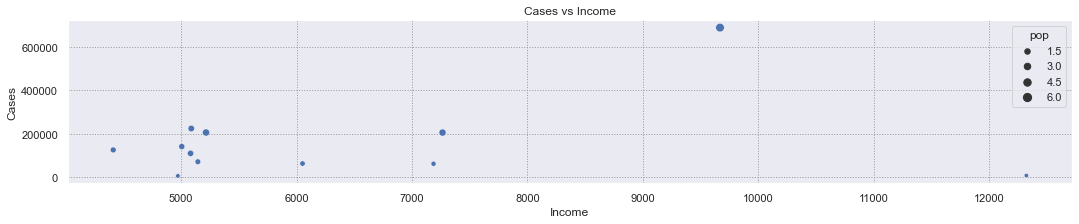

In [349]:
# plot relationship between cases_new and income
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(x='income', y='cases_new', size='pop', data=cases_income)
plt.xlabel('Income')
plt.ylabel('Cases')
plt.title('Cases vs Income')
plt.show()

There appears to be a weak correlation, hinting that Covid cases may not be a totally socio-economic one. As the average income of the state increases, the more populated it generally is, which would mean more cases. The population is a strong **confounding variable**. We can account for the influence of population by taking cases per 100k people instead before plotting.


[Text(0.5, 0, 'Income'), Text(0, 0.5, 'Cases per 10k')]

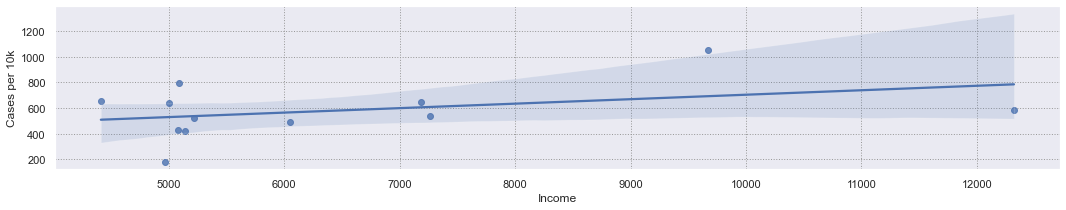

In [513]:
cases_income['cases_per_10k'] = cases_income['cases_new'] / (cases_income['pop'] / 10000)
ax = sns.regplot(x='income', y='cases_per_10k', data=cases_income)
ax.set(xlabel='Income', ylabel='Cases per 10k')

By accounting for the population and considering the income of the state with the cases per 10k of the population, there exists no trend whatsoever. This suggests that the third population variable can make or break a trend. In this case, Covid-19 does not appear to be a socio-economic issue.

### Is there a correlation between vaccination and daily cases at a national level?

We first obtain a new dataframe which only contains the date and the cummulative vaccination head count then we examine their correlation and visualize it using heatmap.

In [205]:
corr_vaccine = vax_malaysia[['date','cumul']]
malaysia_cases = cases_state[['date','state','cases_new']]
filtered_my_cases = malaysia_cases.groupby('date').sum().reset_index()
merged_data_frame = pd.merge(filtered_my_cases, corr_vaccine, on=['date'])
corr_merged_data_frame = merged_data_frame.corr()

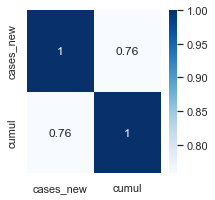

In [206]:
plt.figure(figsize=(3,3))
sns.heatmap(corr_merged_data_frame, annot=True,cmap='Blues')
plt.show()

<AxesSubplot:xlabel='cumul', ylabel='cases_new'>

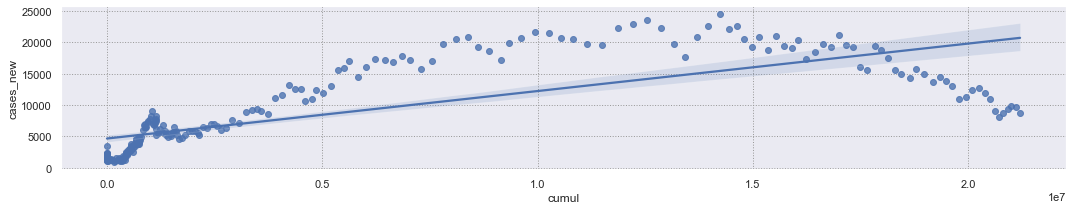

In [207]:
sns.regplot(x='cumul', y='cases_new', data=merged_data_frame)

From the regression plot, we can see that the relationship is not exactly linear. It forms more of a parabolic, **curvilinear** trend towards the beginning. Perhaps it takes a while for the effects of vaccination to kickin, as after a certain volume of vaccines are administered, the number of daily cases are on a downward trend.

### Has vaccination helped reduce daily cases in Selangor, Sabah and Sarawak?

In [461]:
def vaccination_dailycases(state, ax=None):
    state_vax = vax_state[vax_state['state'] == state]
    state_vax['cum'] = state_vax['daily_full'].cumsum()

    state_cases = cases_state[cases_state['state'] == state]

    state_merged = state_cases.merge(state_vax, on=['date'])

    plt.figure(figsize=(7,5))
    sns.regplot(x='cum', y='cases_new', data=state_merged, ax=ax)
    plt.xlabel('Cumulative Vaccinations')
    plt.ylabel('Daily Cases')
    plt.title(f"{state} Cumulative Vaccinations vs Daily Cases")
    plt.show()

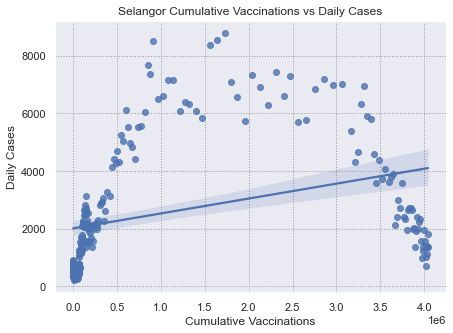

In [209]:
vaccination_dailycases('Selangor')

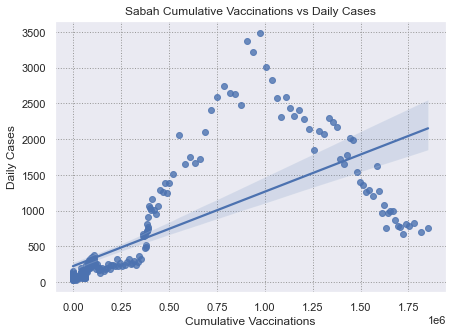

In [460]:
vaccination_dailycases('Sabah')

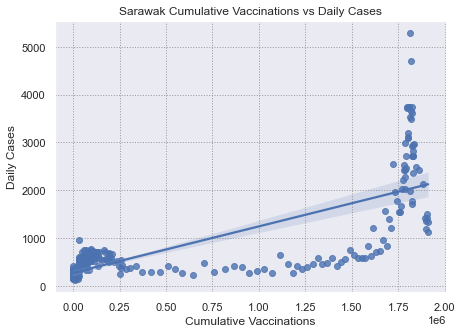

In [211]:
vaccination_dailycases('Sarawak')

<AxesSubplot:title={'center':'National Cumulative Vaccinations vs Daily Cases'}, xlabel='cumul', ylabel='cases_new'>

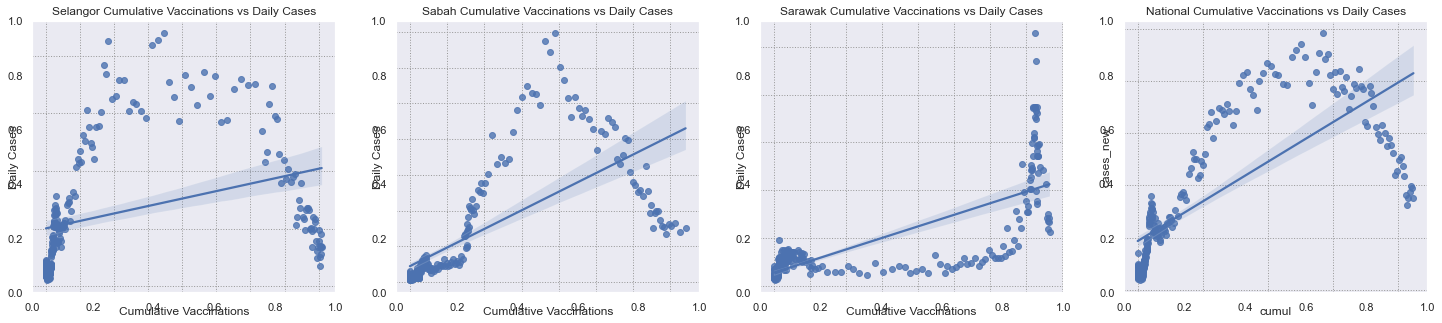

In [523]:
fig, ax = plt.subplots(1, 4, figsize=(25,5))

state = 'Selangor'
state_vax = vax_state[vax_state['state'] == state]
state_vax['cum'] = state_vax['daily_full'].cumsum()

state_cases = cases_state[cases_state['state'] == state]

state_merged = state_cases.merge(state_vax, on=['date'])

ax = fig.add_subplot(141, title=f"{state} Cumulative Vaccinations vs Daily Cases")
ax.set_xticklabels([])
ax.set_yticklabels([])
sns.regplot(x='cum', y='cases_new', data=state_merged, ax=ax)
plt.xlabel('Cumulative Vaccinations')
plt.ylabel('Daily Cases')
plt.title(f"{state} Cumulative Vaccinations vs Daily Cases")

state = 'Sabah'
state_vax = vax_state[vax_state['state'] == state]
state_vax['cum'] = state_vax['daily_full'].cumsum()

state_cases = cases_state[cases_state['state'] == state]

state_merged = state_cases.merge(state_vax, on=['date'])

ax = fig.add_subplot(142, title=f"{state} Cumulative Vaccinations vs Daily Cases")
ax.set_xticklabels([])
ax.set_yticklabels([])
sns.regplot(x='cum', y='cases_new', data=state_merged, ax=ax)
plt.xlabel('Cumulative Vaccinations')
plt.ylabel('Daily Cases')
plt.title(f"{state} Cumulative Vaccinations vs Daily Cases")

state = 'Sarawak'
state_vax = vax_state[vax_state['state'] == state]
state_vax['cum'] = state_vax['daily_full'].cumsum()

state_cases = cases_state[cases_state['state'] == state]

state_merged = state_cases.merge(state_vax, on=['date'])

ax = fig.add_subplot(143, title=f"{state} Cumulative Vaccinations vs Daily Cases")
ax.set_xticklabels([])
ax.set_yticklabels([])
sns.regplot(x='cum', y='cases_new', data=state_merged, ax=ax)
plt.xlabel('Cumulative Vaccinations')
plt.ylabel('Daily Cases')
plt.title(f"{state} Cumulative Vaccinations vs Daily Cases")

ax = fig.add_subplot(144, title=f"National Cumulative Vaccinations vs Daily Cases")
ax.set_xticklabels([])
ax.set_yticklabels([])
sns.regplot(x='cumul', y='cases_new', data=merged_data_frame, ax=ax)

For Selangor and Sabah, there appears to be a curvilinear relationship between cumulative vaccinations and total cases. For the first period, there is a steady increase in cases. However, upon hitting a vaccination threshold, daily cases start to drop, which may be attributed to the effects of vaccination kicking in. Vaccinations have helped reduce daily cases in these two states.

For Sarawak however, there is an exponential increase in cases. We cannot conclude that vaccination has not been effective in this state. Instead, there may be confounding factors involved.

### If daily cases increases, does that also increase the number of people getting vaccinated on a daily basis? Does the government put more effort into the vaccination campaign when cases spike?

We try calculating the correlations only after a certain percentage of the population has been vaccinated, to see whether the trends begin to change.

In [212]:
# prepare a generic function that calculates the cumulative sum of cases and percentage vaccinated for each state with the option
# to remove a certain percentage of the data before doing so (something like alpha trimming)
'''
Inputs: state
Outputs: correlation matrix, dataframe of cumulative cases and percentage vaccinated
'''
def cases_vax_corr(state, mode = 1,percentage = 0):
    vax_state_temp = vax_state.copy()
    vax_state_temp = vax_state_temp[vax_state_temp['state'] == state]
    population_state = population[population['state'] == state]['pop'].iloc[0]
    vax_state_temp['cmul'] = vax_state_temp['daily_full'].cumsum()
    vax_state_temp['percentage_vaccinated'] = vax_state_temp['cmul'] / population_state

    state_cases = cases_state[cases_state['state'] == state]
    if mode == 2 :
        date = vax_state_temp[vax_state_temp['percentage_vaccinated'] >= percentage]['date'].iloc[0]
        state_cases = cases_state[cases_state['date'] >= date]
    state_vax = vax_state[vax_state['state'] == state]
    state_merged = state_cases.merge(state_vax, on='date')
    corr = state_merged[['daily_full', 'cases_new']].corr()
    
    return corr,vax_state_temp,state_merged

For each state, calculate the correlation after 5%, 10% and 15% of the population has been vaccinated. 

In [213]:
corr_selangor1,vax_percentage_selangor1,selangor_state_merged1 = cases_vax_corr('Selangor',1)
corr_selangor2,vax_percentage_selangor2,selangor_state_merged2 = cases_vax_corr('Selangor',2,0.05)
corr_selangor3,vax_percentage_selangor3,selangor_state_merged3 = cases_vax_corr('Selangor',2,0.10)
corr_selangor4,vax_percentage_selangor4,selangor_state_merged4 = cases_vax_corr('Selangor',2,0.15)
corr_sabah1,vax_percentage_sabah1,sabah_state_merged1 = cases_vax_corr('Sabah',1)
corr_sabah2,vax_percentage_sabah2,sabah_state_merged2 = cases_vax_corr('Sabah',2,0.05)
corr_sabah3,vax_percentage_sabah3,sabah_state_merged3 = cases_vax_corr('Sabah',2,0.15)
corr_sabah4,vax_percentage_sabah4,sabah_state_merged4 = cases_vax_corr('Sabah',2,0.2)
corr_sarawak1,vax_percentage_sarawak1,sarawak_state_merged1= cases_vax_corr('Sarawak',1)
corr_sarawak2,vax_percentage_sarawak2,sarawak_state_merged2= cases_vax_corr('Sarawak',2,0.05)
corr_sarawak3,vax_percentage_sarawak3,sarawak_state_merged3= cases_vax_corr('Sarawak',2,0.15)
corr_sarawak4,vax_percentage_sarawak4,sarawak_state_merged4= cases_vax_corr('Sarawak',2,0.2)

In [214]:
table = {'Full Period':[corr_selangor1['daily_full']['cases_new'], corr_sabah1['daily_full']['cases_new'], corr_sarawak1['daily_full']['cases_new']],
        'When Vacinated Rate Over 0.05':[corr_selangor2['daily_full']['cases_new'], corr_sabah2['daily_full']['cases_new'], corr_sarawak2['daily_full']['cases_new']],
        'When Vacinated Rate Over 0.10':[corr_selangor3['daily_full']['cases_new'], corr_sabah3['daily_full']['cases_new'], corr_sarawak3['daily_full']['cases_new']],
        'When Vacinated Rate Over 0.15':[corr_selangor4['daily_full']['cases_new'], corr_sabah4['daily_full']['cases_new'], corr_sarawak4['daily_full']['cases_new']]}
 
# Creates pandas DataFrame.
table = pd.DataFrame(table, index =['Selangor','Sabah','Sarawak'])
table

,Full Period,When Vacinated Rate Over 0.05,When Vacinated Rate Over 0.10,When Vacinated Rate Over 0.15
Selangor,0.868888,0.149073,0.124465,0.130903
Sabah,0.887923,0.129022,0.148088,0.146401
Sarawak,-0.184678,-0.038726,-0.081525,-0.065913


Based on the table, we can see that the correlation between vaccination and daily cases changes drastically in different periods of the vaccination campaign, showing no noticeable pattern.

In [215]:
vax_state

,date,state,daily_partial,daily_full,daily,daily_partial_child,daily_full_child,cumul_partial,cumul_full,cumul,cumul_partial_child,cumul_full_child,pfizer1,pfizer2,sinovac1,sinovac2,astra1,astra2,cansino,pending
0,2021-02-24,Johor,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2021-02-24,Kedah,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2021-02-24,Kelantan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2021-02-24,Melaka,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2021-02-24,Negeri Sembilan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3643,2021-10-09,Selangor,8166,3877,12043,7822,605,4443582,4044073,8484652,271548,6365,7854,1389,262,2465,0,0,0,73
3644,2021-10-09,Terengganu,3208,3711,6919,3171,64,849598,707453,1553134,107565,3492,3204,631,4,5,0,3054,0,21
3645,2021-10-09,W.P. Kuala Lumpur,4118,1119,5237,3557,280,2953223,2748617,5701501,124102,2602,3907,760,196,334,0,0,17,23
3646,2021-10-09,W.P. Labuan,23,414,437,9,380,80334,70175,150509,8048,2295,23,414,0,0,0,0,0,0


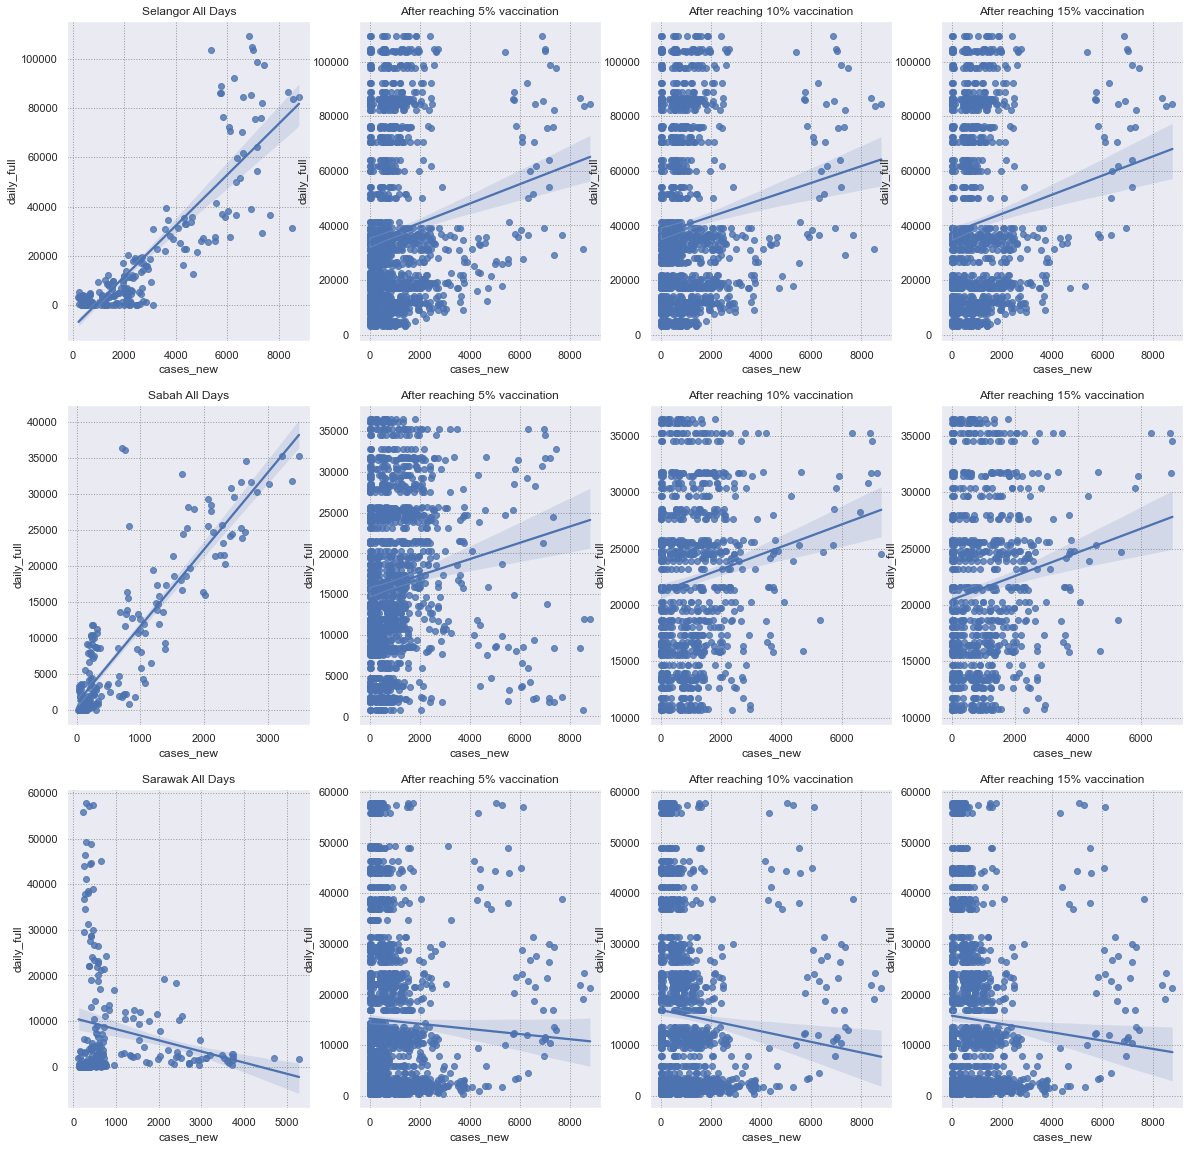

In [216]:
fig, ax = plt.subplots(3, 4, figsize=(20, 20))
sns.regplot(x='cases_new', y='daily_full', data=selangor_state_merged1, ax=ax[0,0]).set(title='Selangor All Days')
sns.regplot(x='cases_new', y='daily_full', data=selangor_state_merged2, ax=ax[0,1]).set(title='After reaching 5% vaccination')
sns.regplot(x='cases_new', y='daily_full', data=selangor_state_merged3, ax=ax[0,2]).set(title='After reaching 10% vaccination')
sns.regplot(x='cases_new', y='daily_full', data=selangor_state_merged4, ax=ax[0,3]).set(title='After reaching 15% vaccination')
sns.regplot(x='cases_new', y='daily_full', data=sabah_state_merged1, ax=ax[1,0]).set(title='Sabah All Days')
sns.regplot(x='cases_new', y='daily_full', data=sabah_state_merged2, ax=ax[1,1]).set(title='After reaching 5% vaccination')
sns.regplot(x='cases_new', y='daily_full', data=sabah_state_merged3, ax=ax[1,2]).set(title='After reaching 10% vaccination')
sns.regplot(x='cases_new', y='daily_full', data=sabah_state_merged4, ax=ax[1,3]).set(title='After reaching 15% vaccination')
sns.regplot(x='cases_new', y='daily_full', data=sarawak_state_merged1, ax=ax[2,0]).set(title='Sarawak All Days')
sns.regplot(x='cases_new', y='daily_full', data=sarawak_state_merged2, ax=ax[2,1]).set(title='After reaching 5% vaccination')
sns.regplot(x='cases_new', y='daily_full', data=sarawak_state_merged3, ax=ax[2,2]).set(title='After reaching 10% vaccination')
sns.regplot(x='cases_new', y='daily_full', data=sarawak_state_merged4, ax=ax[2,3]).set(title='After reaching 15% vaccination')
plt.show()

Show a linechart through the entire vaccination campaign to see which state's vaccination campaign is superior to the others. 

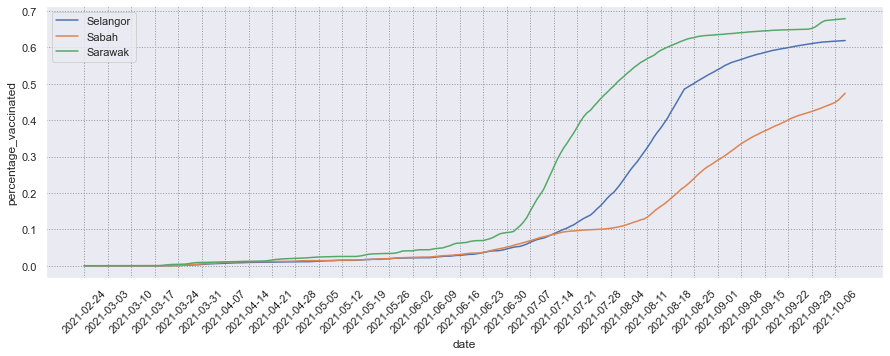

In [217]:
plt.figure(figsize=(15, 5))
sns.lineplot(x='date', y='percentage_vaccinated', data=vax_percentage_selangor1, label='Selangor')
sns.lineplot(x='date', y='percentage_vaccinated', data=vax_percentage_sabah1, label='Sabah')
sns.lineplot(x='date', y='percentage_vaccinated', data=vax_percentage_sarawak1, label='Sarawak')
plt.xticks([i for i in range(0, len(vax_percentage_selangor1), 7)], vax_percentage_selangor1['date'].iloc[::7], rotation=45)
plt.legend()

If we look at the vaccination campaign of the state as a whole, there is a correlation between daily cases and vaccination numbers. However, if you zoom into different periods of the campaign (after hitting 5%, 10% and 15% vaccination rates), there is no pattern between daily cases and daily vaccinations. Regardless of whether cases up or down, the government still continues administering vaccines.

### Which states have been most affected by Covid clusters? (e.g. Kluster Mahkamah, Court Cluster, etc.)

To answer this question, we first split the "states" column into individual states and explode the dataframe. Some Covid clusters span across multiple states, so we have to do this to understand how much the cases of each state are affected by entire clusters.

In [218]:
# iterate row by row through clusters dataframe
import re
clusters['single_state'] = clusters['state'].apply(lambda x: [state.strip().title() for state in re.split(', | & ', x)])
clusters_singlestate = clusters.explode('single_state')
clusters_singlestate = clusters_singlestate[clusters_singlestate['single_state'].isin(['Wp Kuala Lumpur', 'Wp Putrajaya', 'Selangor', 'Negeri Sembilan', 'Pahang', 'Johor', 'Sarawak', 'Kedah', 'Perak', 'Kelantan'])]

In [219]:
clusters_singlestate['cases_total'].describe()

count    5132.000000
mean      112.030398
std       364.416899
min         2.000000
25%        19.000000
50%        38.000000
75%        86.000000
max      7205.000000
Name: cases_total, dtype: float64

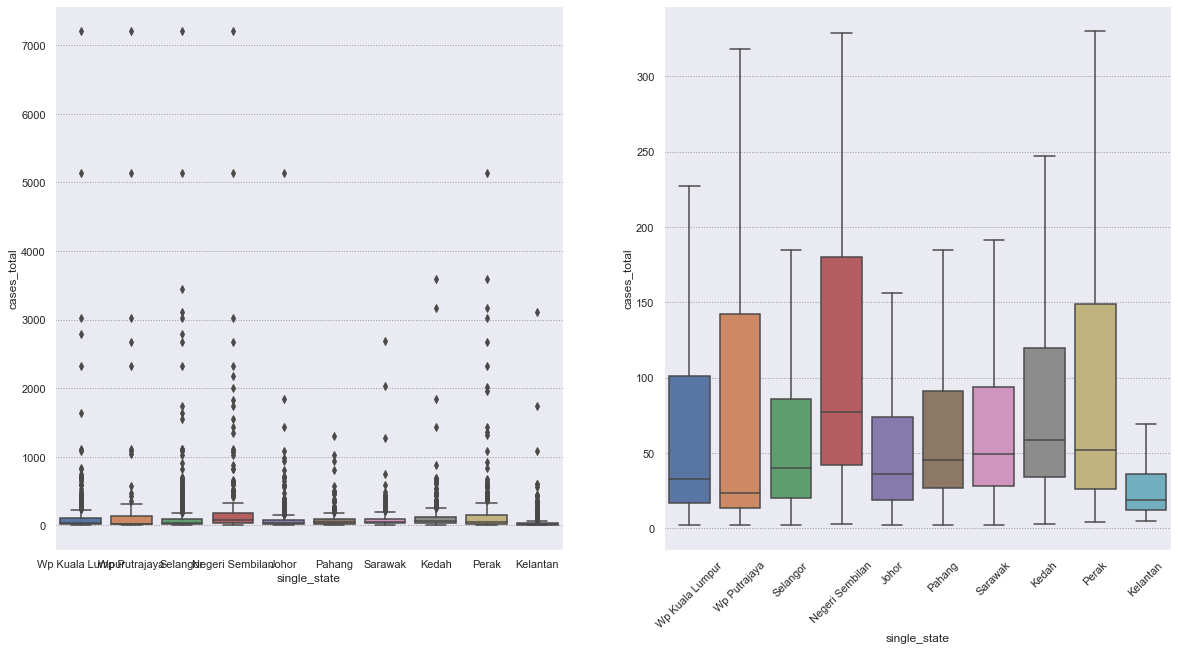

In [220]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
plt.xticks(rotation=45)
sns.boxplot(x='single_state', y='cases_total', data=clusters_singlestate, ax=ax[0])
sns.boxplot(x='single_state', y='cases_total', data=clusters_singlestate, showfliers=False, ax=ax[1])
plt.show()

We can see from the boxplot that the majority of Covid Clusters are moderately sized, often under 100 cases per cluster. However, there does exist unusually large clusters that appear as outliers. 

In this case, to get a more meaningful idea of "ordinary" clusters alone, we remove the outliers and show a new boxplot. Surprisingly, Negeri Sembilan and Perak are most affected by clusters, as opposed to more populated states like Selangor or Kuala Lumpur.

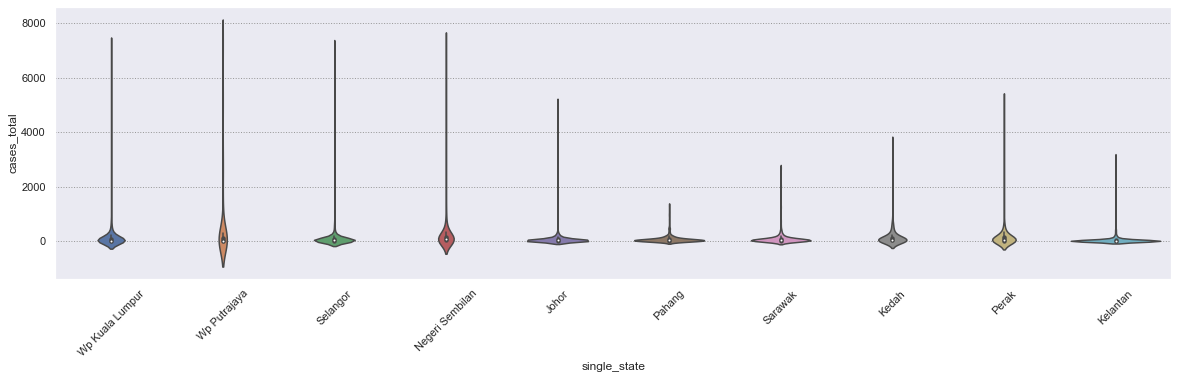

In [221]:
plt.figure(figsize=(20, 5))
sns.violinplot(x='single_state', y='cases_total', data=clusters_singlestate)
plt.xticks(rotation=45)
plt.show()

The violin plot shows us the relative Covid cluster sizes in each state. States like Selangor, Johor, Pahang and Sarawak have mostly small clusters, while Putrajaya and Negeri Sembilan are narrower and have a wide range of cluster sizes, ranging from just a few people to 1000 people. Putrajaya's and Negeri Sembilan's shape is unsurprising, as the earlier boxplot showed just how impactful Covid-19 clusters are in these regions. 

### What type of Covid-19 clusters are most prevalent? Are these clusters forming in workplaces, night markets, schools, etc.?

<AxesSubplot:xlabel='category', ylabel='cases_total'>

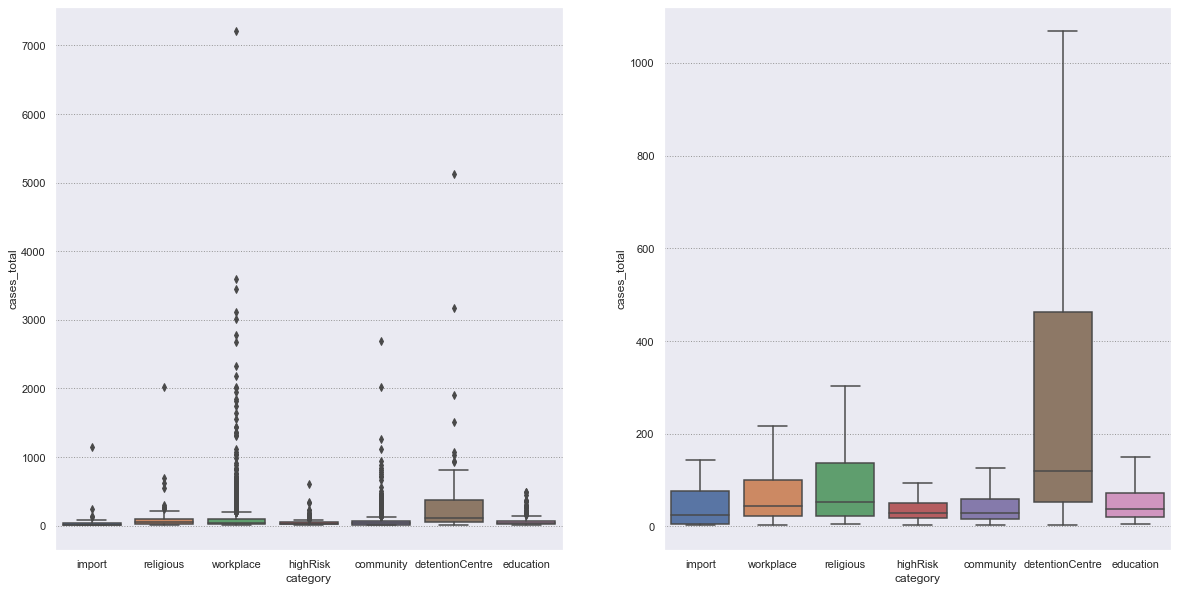

In [222]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.boxplot(x='category', y='cases_total', data=clusters, ax=ax[0])
sns.boxplot(x='category', y='cases_total', data=clusters_singlestate, showfliers=False, ax=ax[1])

The detention centers generally have the largest Covid clusters, with a strong right skew. The rest of the cluster categories have mostly small clusters, but as we observed in the earlier question, there are quite a few unusually large clusters. 

An interesting example is workplace clusters. For instance, most companies/organisations in Malaysia are small, so there may be a **high frequency** of clusters, but only some are **large enough** to appear as an outlier. Case in point, Top Glove.

### How well is Malaysia's vaccination campaign doing compared to other countries in South-East Asia 🌎 ?

To answer this question, we import and clean 🌎 Covid datasets.

In [223]:
global_datasets =  pd.read_csv('./global_datasets/owid-covid-data.csv')
global_datasets

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124194,ZWE,Africa,Zimbabwe,2021-10-12,132016.0,141.0,115.857,4645.0,2.0,2.571,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
124195,ZWE,Africa,Zimbabwe,2021-10-13,132108.0,92.0,96.286,4648.0,3.0,2.571,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
124196,ZWE,Africa,Zimbabwe,2021-10-14,132251.0,143.0,104.000,4655.0,7.0,3.429,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
124197,ZWE,Africa,Zimbabwe,2021-10-15,132285.0,34.0,82.857,4655.0,0.0,3.000,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN


In [224]:
global_datasets.fillna(0, inplace=True)
global_datasets.drop_duplicates(inplace=True)

In [225]:
# remove unnecessary columns
global_datasets.drop(columns=['iso_code', 'continent','new_cases_smoothed','new_deaths_smoothed','new_cases_smoothed_per_million',
                              'new_deaths_smoothed_per_million','reproduction_rate','icu_patients','icu_patients_per_million','hosp_patients',
                              'hosp_patients_per_million','weekly_icu_admissions','weekly_icu_admissions_per_million','weekly_hosp_admissions',
                              'weekly_hosp_admissions_per_million','new_tests_smoothed','total_boosters','new_vaccinations_smoothed',
                              'total_boosters_per_hundred','new_vaccinations_smoothed_per_million','stringency_index','median_age',
                              'aged_65_older','aged_70_older','gdp_per_capita','extreme_poverty','cardiovasc_death_rate','diabetes_prevalence',
                              'female_smokers','male_smokers','handwashing_facilities','hospital_beds_per_thousand','life_expectancy','human_development_index',
                              'excess_mortality_cumulative_absolute','excess_mortality_cumulative','excess_mortality','excess_mortality_cumulative_per_million',
                             ], inplace=True)
global_datasets.head()

,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,...,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,population,population_density
0,Afghanistan,2020-02-24,5.0,5.0,0.0,0.0,0.126,0.126,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39835428.0,54.422
1,Afghanistan,2020-02-25,5.0,0.0,0.0,0.0,0.126,0.000,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39835428.0,54.422
2,Afghanistan,2020-02-26,5.0,0.0,0.0,0.0,0.126,0.000,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39835428.0,54.422
3,Afghanistan,2020-02-27,5.0,0.0,0.0,0.0,0.126,0.000,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39835428.0,54.422
4,Afghanistan,2020-02-28,5.0,0.0,0.0,0.0,0.126,0.000,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39835428.0,54.422


In [226]:
# define a function to return vaccination data beyond a certain date
# we choose April 2021 because this is when Malaysia's 🇲🇾 vaccination campaign kicked off
def getCountry(country) :
    filter = global_datasets['location'] == country
    df = global_datasets[filter]
    df = df[['date','population','people_fully_vaccinated']]
    df['cumul'] = df['people_fully_vaccinated'].cumsum()
    df['percentage_vaccinated'] = df['cumul'] / df['population']
    filter2 = df['date'] > '2021-04'
    df = df[filter2]
    return df

In [227]:
# get vaccination data for each country
Brunei = getCountry('Brunei')
Myanmar = getCountry('Myanmar')
Cambodia = getCountry('Cambodia')
Indonesia = getCountry('Indonesia')
Laos = getCountry('Laos')
Malaysia = getCountry('Malaysia')
Philippines = getCountry('Philippines')
Singapore = getCountry('Singapore')
Thailand = getCountry('Thailand')
Vietnam = getCountry('Vietnam')

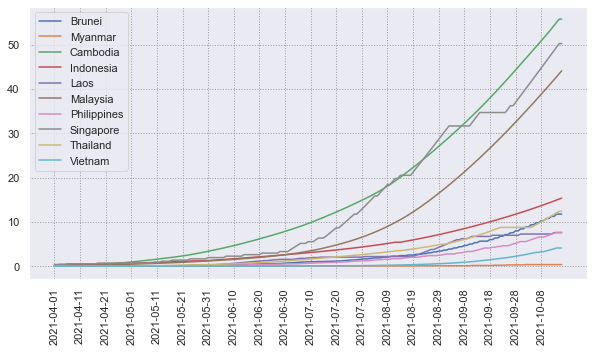

In [525]:
# plot line charts of the vaccination rate of each country
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(Brunei['date'], Brunei['percentage_vaccinated'], label = "Brunei")
ax.plot(Myanmar['date'], Myanmar['percentage_vaccinated'], label = "Myanmar")
ax.plot(Cambodia['date'], Cambodia['percentage_vaccinated'], label = "Cambodia")
ax.plot(Indonesia['date'], Indonesia['percentage_vaccinated'], label = "Indonesia")
ax.plot(Laos['date'], Laos['percentage_vaccinated'], label = "Laos")
ax.plot(Malaysia['date'], Malaysia['percentage_vaccinated'], label = "Malaysia")
ax.plot(Philippines['date'], Philippines['percentage_vaccinated'], label = "Philippines")
ax.plot(Singapore['date'], Singapore['percentage_vaccinated'], label = "Singapore")
ax.plot(Thailand['date'], Thailand['percentage_vaccinated'], label = "Thailand")
ax.plot(Vietnam['date'], Vietnam['percentage_vaccinated'], label = "Vietnam")
ax.set_xticks(ax.get_xticks()[::10])
ax.tick_params(axis='x', labelrotation=90)
ax.legend()

The line graph above shows that the vaccination rate for each country in South-East Asia. Based on the result, we can see that Cambodia has the highest vaccination rate compared to other countries. For Malaysia, we ranked top 3 in the graph and the vaccinated rate is near 45%. Hence, we can conclude that Malaysia's vaccination campaign is doing better than the majority of South-East Asia's countries.

**Note: Percentages are on the low end maybe because this dataset is a few weeks old. When countries are vaccinating thousands a day, the percentage will be higher.**

Even still, Malaysia is doing statistically better than other ASEAN nations.

### Is there a correlation between individual casual contacts (contact tracing) and daily cases? If the link is strong, how contagious is Covid-19?

We correlated individual daily contacts with cases.

In [229]:
trace_malaysia

,date,casual_contacts,hide_large,hide_small
0,2021-03-01,7847,0.0,0.0
1,2021-03-02,6419,0.0,0.0
2,2021-03-03,6903,0.0,0.0
3,2021-03-04,7000,0.0,0.0
4,2021-03-05,9152,0.0,0.0
...,...,...,...,...
216,2021-10-03,32301,37.0,604.0
217,2021-10-05,37312,39.0,841.0
218,2021-10-06,34444,45.0,782.0
219,2021-10-07,39312,43.0,820.0


In [230]:
temp_cases_malaysia = cases_malaysia.copy()
temp_trace_malaysia = trace_malaysia.copy()

<AxesSubplot:xlabel='casual_contacts', ylabel='cases_new'>

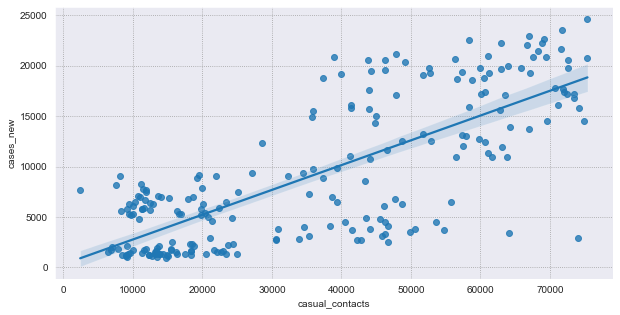

In [97]:
plt.figure(figsize=(10,5))
sns.regplot(x='casual_contacts', y='cases_new', data=merged)

<AxesSubplot:>

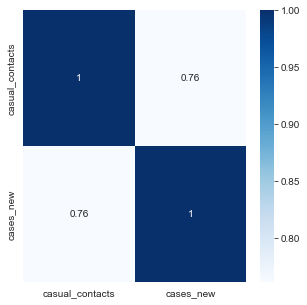

In [ ]:
merged = temp_cases_malaysia.merge(temp_trace_malaysia, on='date')
corr = merged[['casual_contacts', 'cases_new']].corr()
plt.figure(figsize=(5,5))
sns.heatmap(corr, annot=True,cmap='Blues')

Based on both the heatmap and the regression plot, we can see that daily new cases are highly correlated with the number of casual contacts for the day. As in, if more people go out and come in close contact with infected people, the number of cases increases. The statistics fall in line with the science behind Covid-19 🦠.

<img src="./social-distancing.gif">

### How have daily vaccination numbers changed over time across states?

We first normalize both the vaccination rate(%) and the daily new cases of covid cases to see if there's any effect of vaccination. We specifically look at the top 5 states that require more attention( Melaka, Negeri Sembilan, Perlis, Selangor and W.P. Putrajaya) that we found out that have low vaccination rate in the earlier finding.

In [233]:
grouped_malaysia_cases = malaysia_cases.groupby(['date','state']).sum().reset_index()

grouped_malaysia_cases.head()
#fig, ax = plt.subplots(figsize=(15,7))
#grouped = malaysia_cases.groupby(['date','state']).sum().unstack().plot(ax=ax)

,date,state,cases_new
0,2020-01-25,Johor,4
1,2020-01-25,Kedah,0
2,2020-01-25,Kelantan,0
3,2020-01-25,Melaka,0
4,2020-01-25,Negeri Sembilan,0


In [234]:
vax_state = vax_state[['date','state','daily_full']]
merged_vax_state = pd.merge(vax_state, malaysia_cases, on=['date','state'])
merged_vax_state

,date,state,daily_full,cases_new
0,2021-02-24,Johor,0,318
1,2021-02-24,Kedah,0,17
2,2021-02-24,Kelantan,0,53
3,2021-02-24,Melaka,0,26
4,2021-02-24,Negeri Sembilan,0,1392
...,...,...,...,...
3643,2021-10-09,Selangor,3877,1351
3644,2021-10-09,Terengganu,3711,590
3645,2021-10-09,W.P. Kuala Lumpur,1119,288
3646,2021-10-09,W.P. Labuan,414,1


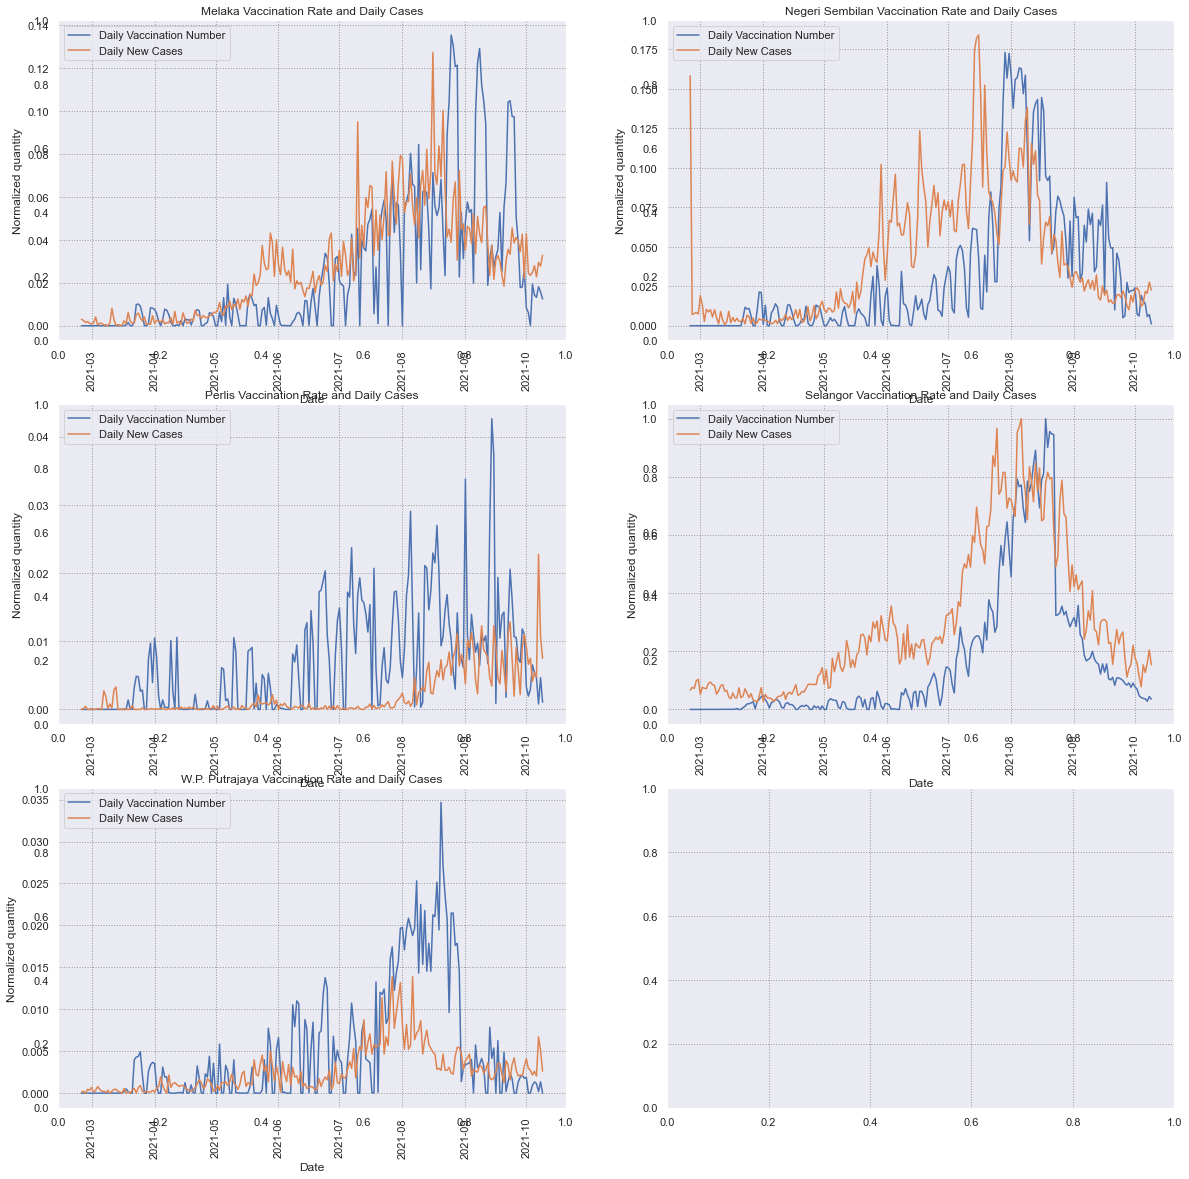

In [235]:
from sklearn import preprocessing
import matplotlib.pyplot as plt

#states = ['Johor','Kedah','Kelantan','Melaka','Negeri Sembilan','Pahang','Perak','Perlis','Pulau Pinang','Sabah',
#          'Sarawak','Selangor','Terengganu','W.P. Kuala Lumpur','W.P. Labuan','W.P. Putrajaya']

states = ['Melaka','Negeri Sembilan','Perlis','Selangor','W.P. Putrajaya']

scaler = preprocessing.MinMaxScaler()
names = ['cases_new','daily_full']
d = scaler.fit_transform(merged_vax_state[['cases_new','daily_full']])
scaled_df = pd.DataFrame(d, columns=names)
scaled_df['date'] = pd.to_datetime(merged_vax_state['date'])
scaled_df['state'] = merged_vax_state['state']

fig, axes = plt.subplots(3, 2, figsize=(20,20))

#scaled_df[scaled_df['state']==i]['date'],
for index, i in enumerate(states):
    ax = fig.add_subplot(3, 2, index + 1)
    ax.plot(scaled_df[scaled_df['state']==i]['date'],scaled_df[scaled_df['state']==i]['daily_full'],label = "Daily Vaccination Number")
    ax.plot(scaled_df[scaled_df['state']==i]['date'],scaled_df[scaled_df['state']==i]['cases_new'],label = "Daily New Cases")
    plt.xticks(rotation=90)
    plt.title(i + ' Vaccination Rate and Daily Cases')
    plt.xlabel('Date')
    plt.ylabel('Normalized quantity')
    leg = plt.legend(loc='upper left')

plt.show()

 As we can see from the line graph that we plot out, it is clear that when the government put more effort into getting the people vaccinated in that certain state, the daily cases would start to decline, except for Perlis. Perlis's daily cases spikes up a little in October 2021 but not drastically. We can safely assume that vaccination actually in a way help controlling the cluster cases in Perlis without going higher. Regardless, we can conclude that vaccination might be one of the contributing factor to reduce daily covid cases in Malaysia. However, more research is needed in order to conclude this finding. 

### How has the vaccination rate changed across the nation?

We make a new dataframe to store the cumulative population that have already get their full vaccination then, and a new column to store the percentage of the population which is derrived from the cumulative population. Lastly we plot out a line graph to visualize the vaccination rate across the whole Malaysia

In [236]:
vax_pop_percentage = vax_malaysia['cumul']
vax_pop_percentage = pd.DataFrame(vax_pop_percentage)
vax_pop_percentage['percentage'] = vax_pop_percentage.apply(lambda x: (vax_malaysia['cumul']/population[population['state']=='Malaysia']['pop'].item())*100,axis=0)
vax_pop_percentage['date'] = pd.to_datetime(vax_malaysia['date'])
vax_pop_percentage

,cumul,percentage,date
0,0,0.000000,2021-02-24
1,0,0.000000,2021-02-25
2,1,0.000003,2021-02-26
3,2,0.000006,2021-02-27
4,5,0.000015,2021-02-28
...,...,...,...
223,20819254,63.750495,2021-10-05
224,20915720,64.045882,2021-10-06
225,21004275,64.317046,2021-10-07
226,21104896,64.625157,2021-10-08


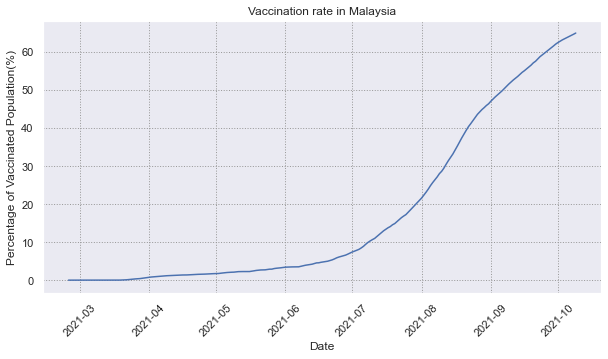

In [237]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.lineplot(x='date', y='percentage', data=vax_pop_percentage)
plt.xlabel('Date')
plt.ylabel('Percentage of Vaccinated Population(%)')
plt.xticks(rotation=45)
plt.title('Vaccination rate in Malaysia')
plt.show()

If we consider the population of Malaysia as a whole, we have just crossed the 60% vaccination threshold. There does seem to be a slow start, but the speed of the campaign has picked up.

### Which vaccines 💉 have been used the most? 
There has been a lot of debate about this. Malaysia is one of few countries that chooses to buy a variety of vaccines and even switched from Sinovac to Pfizer in the middle of the campaign, so it is interesting to see which vaccines were used to inoculate the majority of the population and their general daily adoption.

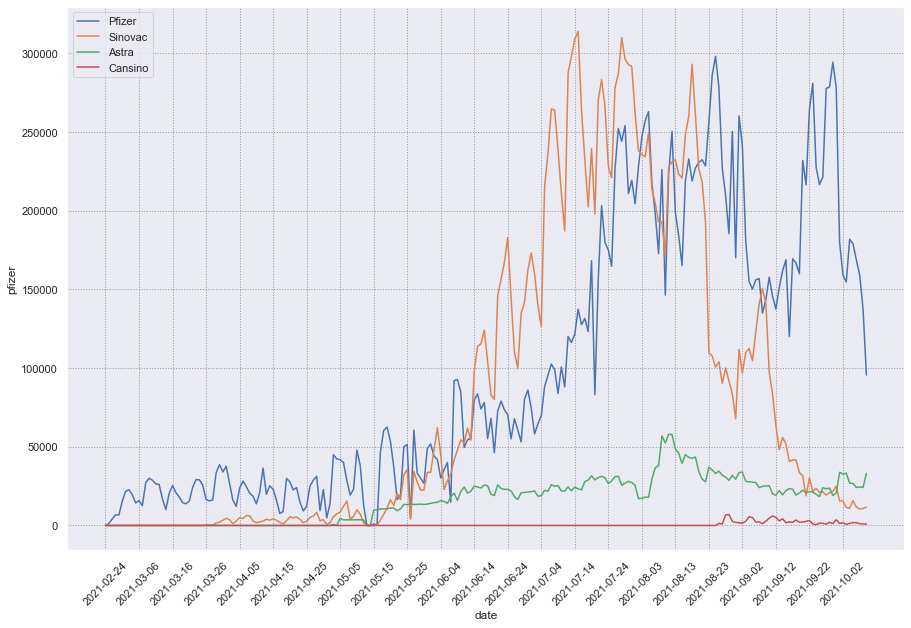

In [238]:
plt.figure(figsize=(15, 10))
sns.lineplot(x='date', y='pfizer', data=vax_malaysia_all_attributes)
sns.lineplot(x='date', y='sinovac', data=vax_malaysia_all_attributes)
sns.lineplot(x='date', y='astra', data=vax_malaysia_all_attributes)
sns.lineplot(x='date', y='cansino', data=vax_malaysia_all_attributes)
# only show some xtick labels
plt.xticks([date for i, date in enumerate(vax_malaysia_all_attributes['date']) if i % 10 == 0], rotation=45)
plt.legend(['Pfizer', 'Sinovac', 'Astra', 'Cansino'])
plt.show()

At the start of the campaign, MoH was primarily using Pfizer, but by June, Sinovac would rapidly overtake Pfizer to become the most used vaccine. Adoption of Sinovac however drops, but people still do come back for their second dose. 

<img src="./sinovac-phaseout.png" width=300>
<br/>
<a href="https://thediplomat.com/2021/07/malaysia-to-phase-out-chinas-sinovac-vaccine/">Link</a>

In [239]:
vaccine_totals = pd.DataFrame(vax_malaysia_all_attributes[['pfizer', 'astra', 'sinovac']].sum().reset_index())
vaccine_totals.columns = ['vaccine', 'total']
vaccine_totals

,vaccine,total
0,pfizer,22755674
1,astra,3714440
2,sinovac,18737007


<AxesSubplot:xlabel='vaccine', ylabel='total'>

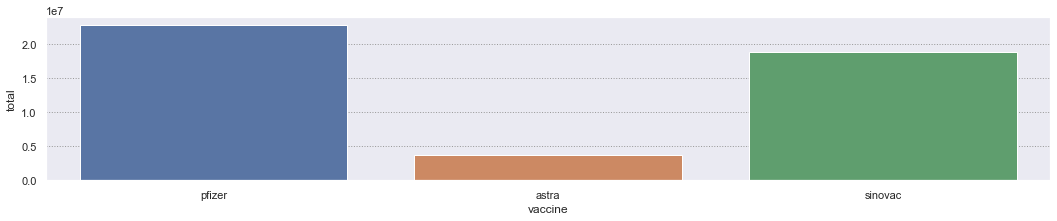

In [240]:
sns.barplot(x='vaccine', y='total', data=vaccine_totals)

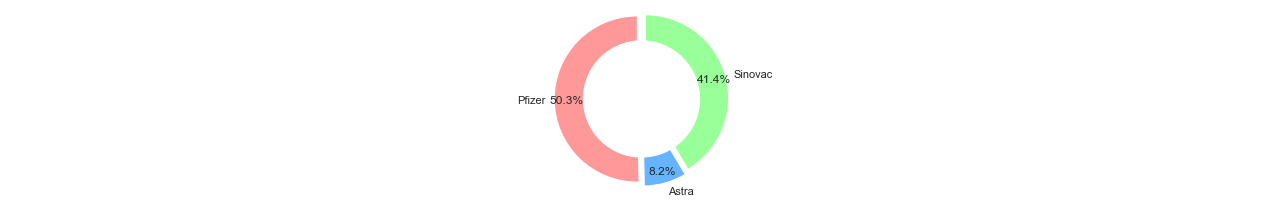

In [241]:
# pie chart of vaccine_totals
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
explode = (0.05, 0.05, 0.05)
fig1, ax1 = plt.subplots()
ax1.pie(vaccine_totals['total'], labels=vaccine_totals['vaccine'].str.title(), colors=colors, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode=explode)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.axis('equal')
plt.tight_layout()
plt.show()

Pfizer is the most used vaccine in Malaysia, followed by Sinovac and then Astrazeneca. If you observe the usage of Astrazeneca, it flails in comparison to the other two because it was opened up for voluntary registrations. Furthermore, unlike Pfizer and Sinovac, Astrazeneca usage does not show an upward trend and only has a few spikes, which may be linked to the times the government opens up registrations.


## Clustering

Time-series clustering can be interactively visualised in Streamlit, so we encourage you to check out the Clustering page.

### How did the clusters change over time with respect to cases and deaths? Did some states reorganise into new clusters?

Each cluster point is considered as one state. After this, we cumulatively total up cases and deaths for each month in a state and pass this data into clustering algorithms, namely K-Means and Density-based Clustering (DBSCAN). 

Different states are of different sizes, so we have to consider the size of each state when clustering. **Therefore, before clustering, we find the cases per 10,000 people in each state.**

In [242]:
states = vax_state['state'].unique()
states

array(['Johor', 'Kedah', 'Kelantan', 'Melaka', 'Negeri Sembilan',
       'Pahang', 'Perak', 'Perlis', 'Pulau Pinang', 'Sabah', 'Sarawak',
       'Selangor', 'Terengganu', 'W.P. Kuala Lumpur', 'W.P. Labuan',
       'W.P. Putrajaya'], dtype=object)

#### KMeans

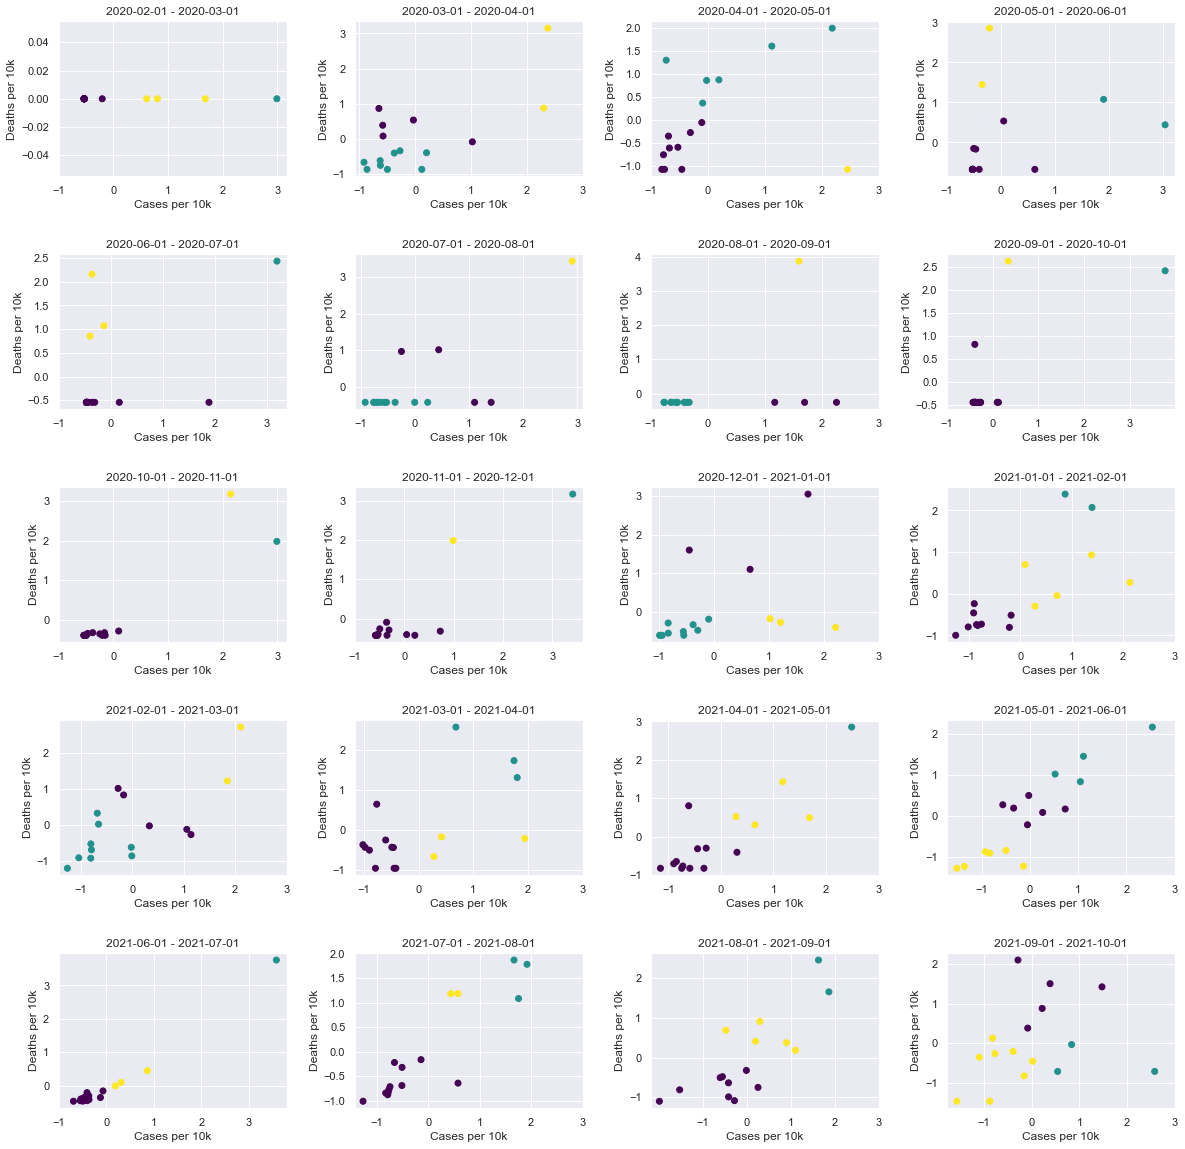

In [243]:
sns.set(rc={'figure.figsize':(18, 3)})
nrows = 5
ncols = 4
fig, axes = plt.subplots(5, 4, figsize=(20, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.3)
fig.set_visible(True)

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

grid_combos = []
for i in range(1, 25):
    grid_combos.append((nrows, ncols, i))

dates = ['2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01']
ranges = [(dates[i], dates[i+1]) for i in range(len(dates)-1)]

for i, date_range in enumerate(ranges):
    cases_state_date = cases_state[(cases_state['date'] >= date_range[0]) & (cases_state['date'] < date_range[1])]
    deaths_state_date = deaths_state[(deaths_state['date'] >= date_range[0]) & (deaths_state['date'] < date_range[1])]
    
    cases = []
    vaccinations = []
    deaths = []

    for state in states:
        cases.append((cases_state_date[cases_state_date['state'] == state]['cases_new'].sum()) / (population[population['state'] == state]['pop'].values[0] / 10000))
        deaths.append(deaths_state_date[deaths_state_date['state'] == state]['deaths_new'].sum() / (population[population['state'] == state]['pop'].values[0] / 10000))

    cases_deaths_vaccinations = pd.DataFrame({"state": states, "cases": cases, "deaths": deaths})
    for col in cases_deaths_vaccinations:
        if cases_deaths_vaccinations[col].dtype != 'object':
            cases_deaths_vaccinations[col] = StandardScaler().fit_transform(cases_deaths_vaccinations[[col]])

    cases_deaths_vaccinations.drop(columns=['state'], inplace=True)
    X_std = cases_deaths_vaccinations

    km = KMeans(n_clusters=3, max_iter=100)
    y_clusters = km.fit_predict(cases_deaths_vaccinations)
    centroids = km.cluster_centers_

    row, col, num = grid_combos[i]

    ax = fig.add_subplot(row, col, num)
    ax.scatter(cases_deaths_vaccinations['cases'], cases_deaths_vaccinations['deaths'], c=y_clusters, cmap='viridis')
    ax.set_xlabel('Cases per 10k')
    ax.set_ylabel('Deaths per 10k')
    ax.set_xticks(np.arange(-1, 4, 1))
    # ax.set_yticks(np.arange(-0.05, 3.5, 0.5))
    ax.set_title(f"{date_range[0]} - {date_range[1]}")

In [244]:
cases_deaths_vaccinations['cluster'] = y_clusters
cases_deaths_vaccinations['state'] = states
cases_deaths_vaccinations[cases_deaths_vaccinations['cluster'] == 1]

,cases,deaths,cluster,state
2,0.837361,-0.029458,1,Kelantan
10,2.579574,-0.706055,1,Sarawak
12,0.544457,-0.706341,1,Terengganu


#### DBSCAN

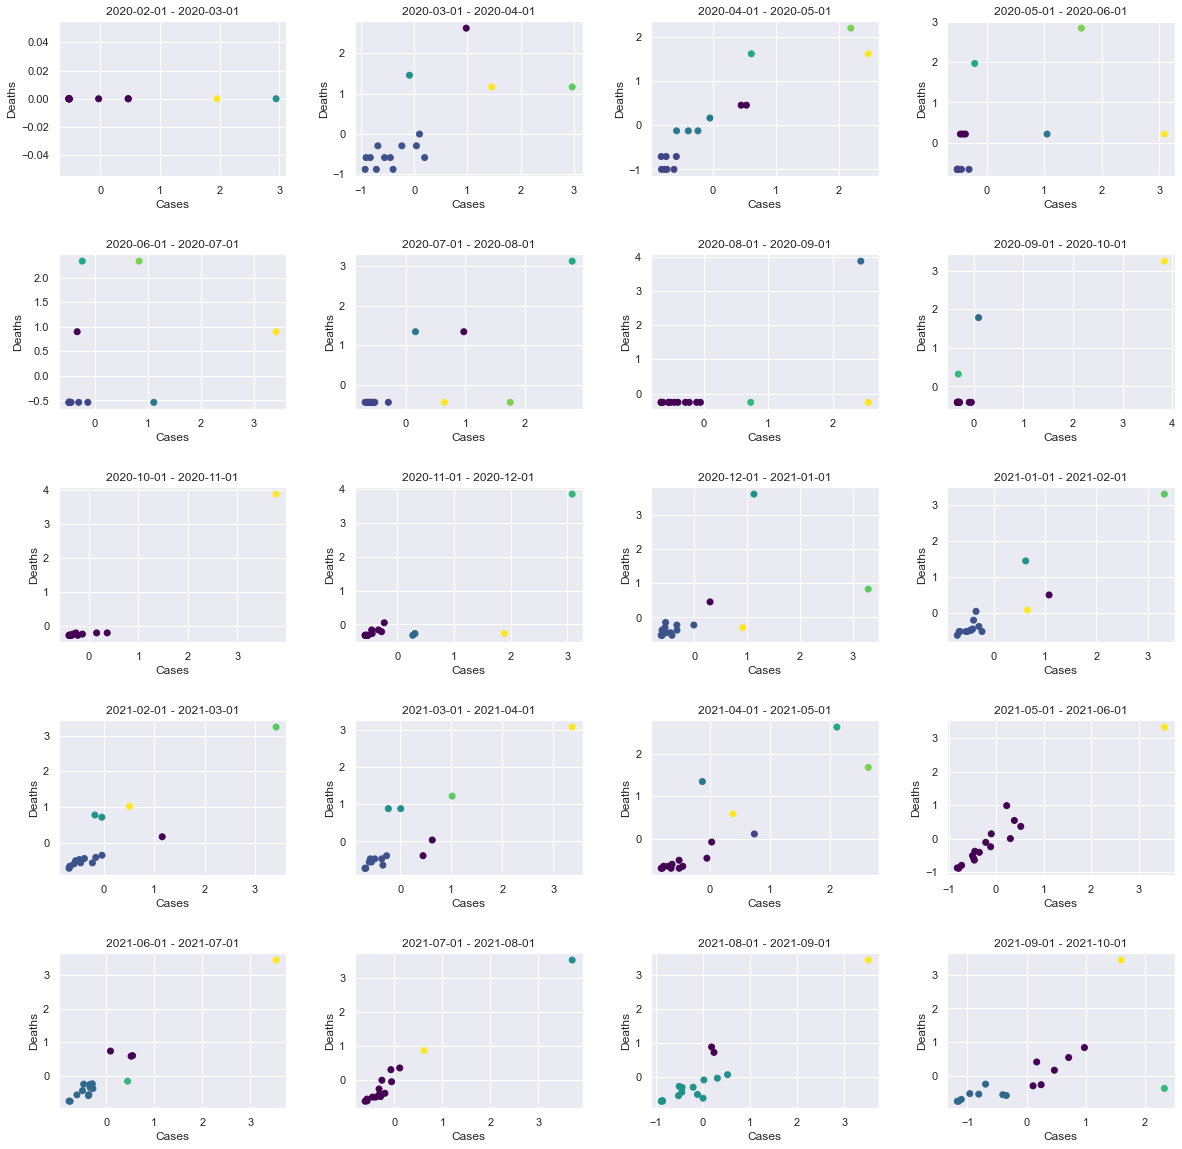

In [245]:
nrows = 5
ncols = 4
fig, axes = plt.subplots(5, 4, figsize=(20, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.3)
fig.set_visible(True)

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

grid_combos = []
for i in range(1, 25):
    grid_combos.append((nrows, ncols, i))

dates = ['2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01']
ranges = [(dates[i], dates[i+1]) for i in range(len(dates)-1)]

for i, date_range in enumerate(ranges):
    cases_state_date = cases_state[(cases_state['date'] >= date_range[0]) & (cases_state['date'] < date_range[1])]
    deaths_state_date = deaths_state[(deaths_state['date'] >= date_range[0]) & (deaths_state['date'] < date_range[1])]
    
    cases = []
    vaccinations = []
    deaths = []

    for state in states:
        cases.append(cases_state_date[cases_state_date['state'] == state]['cases_new'].sum())
        deaths.append(deaths_state_date[deaths_state_date['state'] == state]['deaths_new'].sum())

    cases_deaths_vaccinations = pd.DataFrame({"state": states, "cases": cases, "deaths": deaths})
    for col in cases_deaths_vaccinations:
        if cases_deaths_vaccinations[col].dtype != 'object':
            cases_deaths_vaccinations[col] = StandardScaler().fit_transform(cases_deaths_vaccinations[[col]])

    cases_deaths_vaccinations.drop(columns=['state'], inplace=True)
    X_std = cases_deaths_vaccinations

    dbscan = DBSCAN(eps=0.5, min_samples=1).fit(cases_deaths_vaccinations)
    y_clusters = dbscan.fit_predict(cases_deaths_vaccinations)

    row, col, num = grid_combos[i]

    ax = fig.add_subplot(row, col, num)
    ax.scatter(cases_deaths_vaccinations['cases'], cases_deaths_vaccinations['deaths'], c=y_clusters, cmap='viridis')
    ax.set_xlabel('Cases')
    ax.set_ylabel('Deaths')
    # ax.set_xticks(np.arange(-1, 4, 1))
    # ax.set_yticks(np.arange(-0.05, 3.5, 0.5))
    ax.set_title(f"{date_range[0]} - {date_range[1]}")

We can observe that in the beginning, the majority of the clusters were positioned towards the bottom left and they maintain a similar pattern until about August 2020. In August, the cases were still high but there were fewer deaths, which may signify that the situation was improving, besides the one state that is in the upper corner of the plot that stands out from the rest. Around December, the bottom-right cluster begins to break up and states start moving diagonally upwards in the graph, meaning higher number of deaths and more cases. By September 2021, the states fall in a sort of straight diagonal line, with the performance of states spread across the spectrum from mild to serious. 

By October 2021, K-Means indicates the formation of 3 main clusters:
1. Low Cases and Low Deaths
2. High Cases and High Deaths
3. High Cases and Low Deaths

If there are low deaths despite high cases, then that is acceptable because vaccines have been known to reduce the seriousness of cases. However, the states in "high cases and high deaths" need to be looked at: 
1. Johor
2. Kedah
3. Pulau Pinang
4. Sabah
5. Selangor

### How did the clusters change over time with respect to cases, deaths and vaccinations? Did some states reorganise into new clusters?

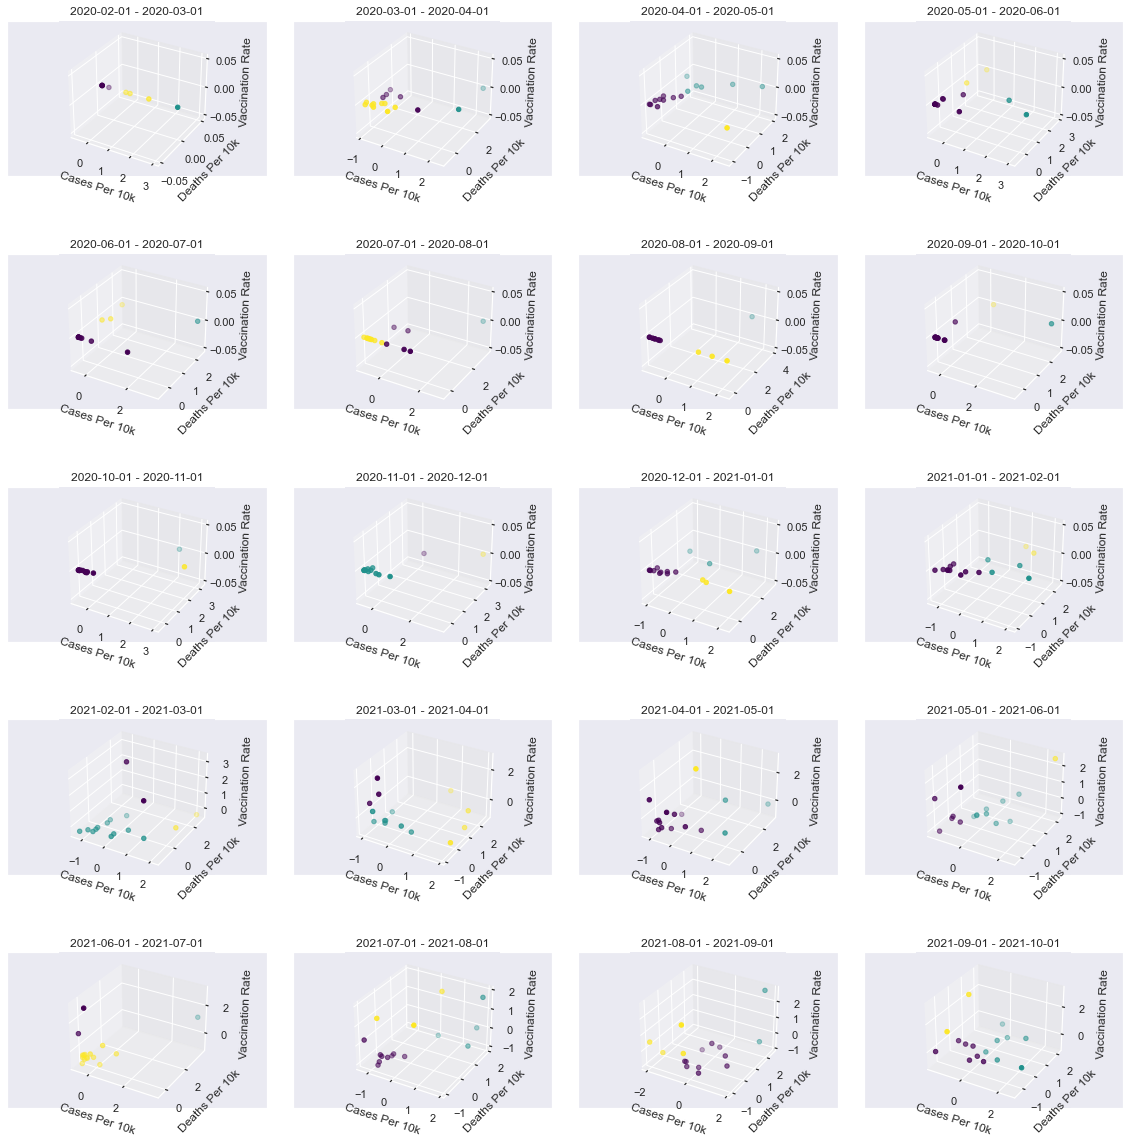

In [246]:
sns.set(rc={'figure.figsize':(18, 3)})
nrows = 5
ncols = 4
fig, axes = plt.subplots(5, 4, figsize=(20, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.1)
fig.set_visible(True)

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

grid_combos = []
for i in range(1, 25):
    grid_combos.append((nrows, ncols, i))

dates = ['2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01']
ranges = [(dates[i], dates[i+1]) for i in range(len(dates)-1)]

for i, date_range in enumerate(ranges):
    cases_state_date = cases_state[(cases_state['date'] >= date_range[0]) & (cases_state['date'] < date_range[1])]
    deaths_state_date = deaths_state[(deaths_state['date'] >= date_range[0]) & (deaths_state['date'] < date_range[1])]
    vax_state_date = vax_state[(vax_state['date'] < date_range[1])]
    
    cases = []
    vaccinations = []
    deaths = []

    for state in states:
        cases.append((cases_state_date[cases_state_date['state'] == state]['cases_new'].sum()) / (population[population['state'] == state]['pop'].values[0] / 10000))
        deaths.append(deaths_state_date[deaths_state_date['state'] == state]['deaths_new'].sum() / (population[population['state'] == state]['pop'].values[0] / 10000))
        vaccinations.append(vax_state_date[vax_state_date['state'] == state]['daily_full'].sum() / population.loc[population['state'] == state, 'pop'].values[0])

    cases_deaths_vaccinations = pd.DataFrame({"state": states, "cases": cases, "deaths": deaths, "vaccinations": vaccinations})
    for col in cases_deaths_vaccinations:
        if cases_deaths_vaccinations[col].dtype != 'object':
            cases_deaths_vaccinations[col] = StandardScaler().fit_transform(cases_deaths_vaccinations[[col]])

    cases_deaths_vaccinations.drop(columns=['state'], inplace=True)
    X_std = cases_deaths_vaccinations
    
    km = KMeans(n_clusters=3, max_iter=100)
    y_clusters = km.fit_predict(cases_deaths_vaccinations)
    centroids = km.cluster_centers_

    row, col, num = grid_combos[i]

    ax = fig.add_subplot(row, col, num, projection='3d')
    ax.scatter(cases_deaths_vaccinations['cases'], cases_deaths_vaccinations['deaths'], cases_deaths_vaccinations['vaccinations'], c=y_clusters, cmap='viridis')
    ax.set_xlabel('Cases Per 10k')
    ax.set_ylabel('Deaths Per 10k')
    ax.set_zlabel('Vaccination Rate')
    ax.set_title(f"{date_range[0]} - {date_range[1]}")

We maintain that states can be grouped into 3 clusters. Throughout 2020, vaccinations are 0 and hence, the clusters slowly start to expand in terms of cases and deaths. By 2021, the states have spread reasonably wide throughout the 3 dimensions and cases and deaths are at an all time high. 

Around this time, vaccination begins and clusters start moving higher in the "vaccination" dimension. As most states move vertically upward in the dimension, there are still a cluster of states with low vaccination rates.

By October 2021, most states are on the upper end of the vaccination spectrum, the lower end of the deaths spectrum, but cases are still spread wide across. This may not be too consequential, because the fact that an increase in cases did not lead to an increase deaths shows the effect of the 💉 campaign.

### Which states require attention in terms of their vaccination campaign and deaths (relatively speaking)?

By clustering a state based on vaccinations and deaths, those that relatively have low vaccination rates and high deaths are deemed to be the states that require attention.

In [247]:
vax_malaysia['daily_adults'] = vax_malaysia['daily_full'] - vax_malaysia['daily_full_child']
vax_malaysia['daily_adults'].describe()

count       228.000000
mean      92118.745614
std       96665.911544
min           0.000000
25%        9096.250000
50%       46677.000000
75%      161489.000000
max      359852.000000
Name: daily_adults, dtype: float64

In [248]:
# only want 
population['adult'] = population['pop_18'] + population['pop_60']

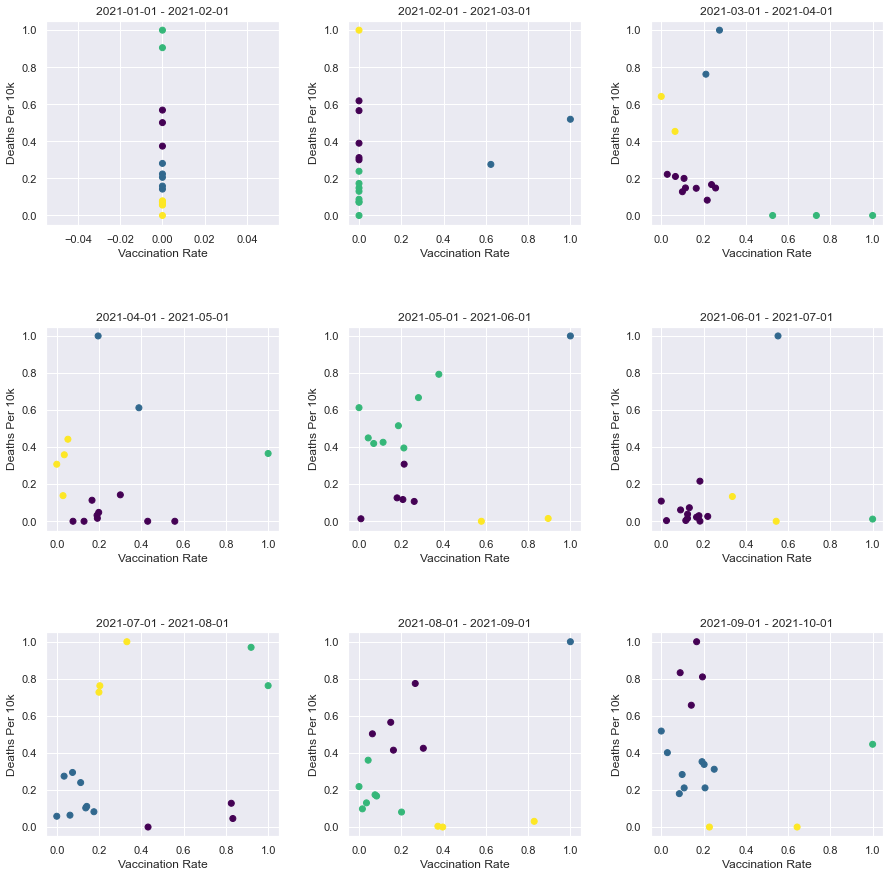

In [589]:
sns.set(rc={'figure.figsize':(18, 3)})
nrows = 3
ncols = 3
fig, axes = plt.subplots(3, 3, figsize=(15, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.3)
fig.set_visible(True)

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

grid_combos = []
for i in range(1, 20):
    grid_combos.append((nrows, ncols, i))

dates = ['2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01']
ranges = [(dates[i], dates[i+1]) for i in range(len(dates)-1)]

for i, date_range in enumerate(ranges):
    cases_state_date = cases_state[(cases_state['date'] >= date_range[0]) & (cases_state['date'] < date_range[1])]
    deaths_state_date = deaths_state[(deaths_state['date'] >= date_range[0]) & (deaths_state['date'] < date_range[1])]
    vax_state_date = vax_state[vax_state['date'] < date_range[1]]

    cases = []
    vaccination_rates = []
    deaths = []

    for state in states:
        cases.append((cases_state_date[cases_state_date['state'] == state]['cases_new'].sum()) / (population[population['state'] == state]['pop'].values[0] / 10000))
        deaths.append((deaths_state_date[deaths_state_date['state'] == state]['deaths_new'].sum()) / (population[population['state'] == state]['pop'].values[0] / 10000))
        vaccination_rates.append(vax_state_date[vax_state_date['state'] == state]['daily_full'].sum() / population.loc[population['state'] == state, 'pop'].values[0])

    cases_deaths_vaccinations = pd.DataFrame({"state": states, "deaths": deaths, "vaccination_rate": vaccination_rates})

    for col in cases_deaths_vaccinations:
        if cases_deaths_vaccinations[col].dtype != 'object':
            cases_deaths_vaccinations[col] = MinMaxScaler().fit_transform(cases_deaths_vaccinations[[col]])

    cases_deaths_vaccinations.drop(columns=['state'], inplace=True)
    X_std = cases_deaths_vaccinations

    km = KMeans(n_clusters=4, max_iter=100)
    y_clusters = km.fit_predict(cases_deaths_vaccinations)
    centroids = km.cluster_centers_

    # put back state column
    cases_deaths_vaccinations['state'] = states

    row, col, num = grid_combos[i]

    ax = fig.add_subplot(row, col, num)
    ax.scatter(cases_deaths_vaccinations['vaccination_rate'], cases_deaths_vaccinations['deaths'], c=y_clusters, cmap='viridis')
    ax.set_xlabel('Vaccination Rate')
    ax.set_ylabel('Deaths Per 10k')
    # ax.set_xticks(np.arange(-0.5, 0.5, 0.1))
    # ax.set_yticks(np.arange(-0.05, 3.5, 0.5))
    ax.set_title(f"{date_range[0]} - {date_range[1]}")

In [250]:
cases_deaths_vaccinations['cluster'] = y_clusters
cases_deaths_vaccinations

,deaths,vaccination_rate,state,cluster
0,0.657359,0.142146,Johor,1
1,0.832739,0.089439,Kedah,1
2,0.401400,0.028939,Kelantan,3
3,0.352847,0.192822,Melaka,3
4,0.311890,0.250480,Negeri Sembilan,3
5,0.180088,0.085362,Pahang,3
6,0.283542,0.098854,Perak,3
7,0.337787,0.202814,Perlis,3
8,0.810185,0.194939,Pulau Pinang,1
9,0.517935,0.000000,Sabah,3


In [251]:
cases_deaths_vaccinations[cases_deaths_vaccinations['cluster'] == 1]

,deaths,vaccination_rate,state,cluster
0,0.657359,0.142146,Johor,1
1,0.832739,0.089439,Kedah,1
8,0.810185,0.194939,Pulau Pinang,1
11,1.000000,0.167282,Selangor,1


We can see that throughout 2020, there are 0 vaccinations in all state since the vaccination campaign was yet to start. By February 2021, two states have begun their vaccination campaigns. It speeds up more rapidly by March and April, the vertical clusters start to spread out on the x-axis indicating higher vaccination numbers. In June 2021, there was a remarkable shoot where the y-axis scale completely changed. As of September 2021, the states that may require attention are those with low vaccination rates and high death rates (still very small), namely cluster 1, which contains the following states:
1. Johor
2. Kedah
3. Pulau Pinang
4. Selangor

## Regression

Regression analysis allows us to predict exact Covid statistics using a variety of machine learning and deep learning models.

Hyperparameter tuning involves testing various LSTM models with different depths and units in each layer. Refer to the report for a full summary.

### Can we predict the daily vaccination numbers? 

In [475]:
# vax_population = vax_malaysia.merge(population, on='state')
malaysia_population = population[population['state'] == 'Malaysia']['pop'].iloc[0]
vax_malaysia['cumul'] = vax_malaysia['daily_full'].cumsum()
vax_malaysia['percentage_vaccinated'] = vax_malaysia['cumul'] / malaysia_population

<AxesSubplot:xlabel='date'>

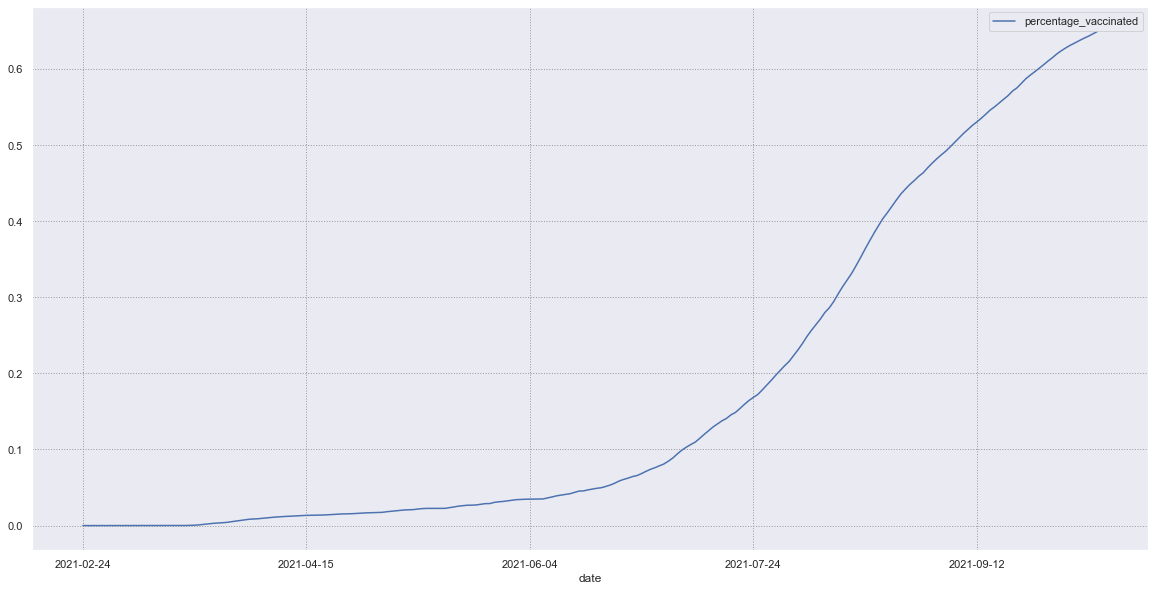

In [476]:
vax_malaysia.plot.line(x='date', y='percentage_vaccinated', figsize=(20,10))

<AxesSubplot:>

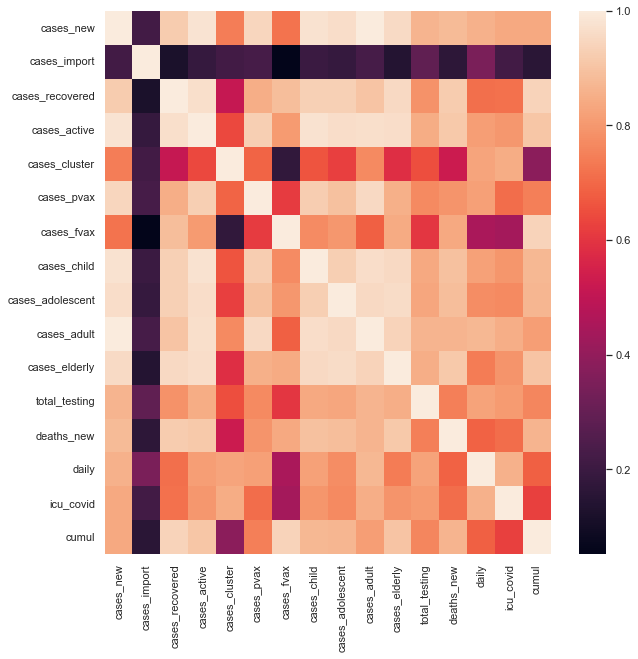

In [477]:
plt.figure(figsize=(10,10))
cases_testing_deaths_vax = cases_malaysia.merge(tests_malaysia, on='date')
cases_testing_deaths_vax = cases_testing_deaths_vax.merge(deaths_malaysia, on='date')
cases_testing_deaths_vax = cases_testing_deaths_vax.merge(vax_malaysia[['date', 'daily']], on='date')
icu_covid = pd.DataFrame(icu.groupby('date')['icu_covid'].sum()).reset_index()
cases_testing_deaths_vax = cases_testing_deaths_vax.merge(icu_covid, on='date')
cases_testing_deaths_vax['cumul'] = cases_testing_deaths_vax['daily'].cumsum()
sns.heatmap(cases_testing_deaths_vax.corr())

In [478]:
cases_testing_deaths_vax.columns

Index(['date', 'cases_new', 'cases_import', 'cases_recovered', 'cases_active',
       'cases_cluster', 'cases_pvax', 'cases_fvax', 'cases_child',
       'cases_adolescent', 'cases_adult', 'cases_elderly', 'total_testing',
       'deaths_new', 'daily', 'icu_covid', 'cumul'],
      dtype='object')

Select best features using Boruta

In [479]:
X = cases_testing_deaths_vax.drop(columns=['date', 'daily', 'cumul'])
y = cases_testing_deaths_vax['daily']

In [256]:
X = cases_testing_deaths_vax.drop(columns=['date', 'daily', 'cumul'])
y = cases_testing_deaths_vax['daily']

rf = RandomForestRegressor(n_jobs=-1, max_depth=5)

# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)

# find all relevant features - 5 features should be selected
feat_selector.fit(X.values, y.ravel())

# check selected features - first 5 features are selected
feat_selector.support_

# check ranking of features
feat_selector.ranking_

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	5
Iteration: 	9 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	5
Iteration: 	10 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	5
Iteration: 	11 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	5
Iteration: 	12 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	5
Iteration: 	13 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	5
Iteration: 	14 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	5
Iteration: 	15 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	5
Iteration: 	16 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	5
Iteration:

array([7, 3, 1, 1, 1, 1, 1, 6, 5, 2, 4, 1, 1, 1])

In [482]:
# # chosen features
# accept = X.columns[feat_selector.support_].to_list()
accept = ["cases_recovered", "cases_active", "cases_cluster",	"cases_pvax", "cases_fvax", "total_testing", "deaths_new", "icu_covid", "daily"]
# accept = ["cases_recovered", "cases_active", "cases_cluster", "cases_pvax", "cases_fvax", "total_testing", "deaths_new", "icu_covid", "daily_cumul"]
# transform dataframe to only selected features
# filtered = pd.DataFrame(feat_selector.transform(X.values), columns=accept)
filtered = cases_testing_deaths_vax[accept]
# add back date and percentage vaccinated
# filtered['daily'] = y
filtered['date'] = cases_testing_deaths_vax['date']
filtered['date'] = pd.to_datetime(filtered['date'])
filtered.set_index('date', inplace=True)
# filtered = pd.read_csv('filtered.csv', index_col=0)

In [483]:
num_features = len(filtered.columns) - 1

#### Multivariate LSTM Time-Series Analysis

In [484]:
filtered

,cases_recovered,cases_active,cases_cluster,cases_pvax,cases_fvax,total_testing,deaths_new,icu_covid,daily
date,,,,,,,,,
2021-02-24,3331,30572,2483.0,0.0,0.0,75122,12,270,60
2021-02-25,3752,28738,705.0,0.0,0.0,85929,13,274,1146
2021-02-26,3085,27903,1136.0,0.0,0.0,80221,10,255,4116
2021-02-27,3320,26937,1100.0,0.0,0.0,63567,10,257,6724
2021-02-28,3251,26118,1404.0,0.0,0.0,59526,9,258,6702
...,...,...,...,...,...,...,...,...,...
2021-10-02,15396,155499,656.0,1306.0,5885.0,102196,109,890,211517
2021-10-03,14454,150019,388.0,1124.0,4944.0,97471,118,860,206574
2021-10-04,15456,142562,731.0,1097.0,4287.0,176380,76,869,221812


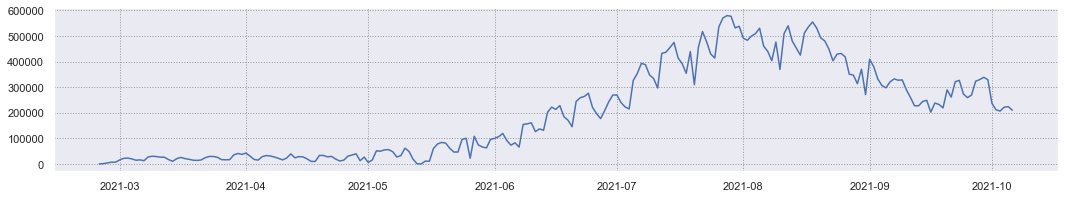

In [485]:
plt.plot(filtered['daily'])

In [486]:
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
input_data = X_scaler.fit_transform(filtered.iloc[:,:-1])
input_y = y_scaler.fit_transform(filtered.iloc[:,-1].values.reshape(-1,1))
input_data = np.concatenate((input_data, input_y), axis=1)

In [487]:
lookback = 100
total_size = input_data.shape[0]

In [488]:
X=[]
y=[]
for i in range(0, total_size - lookback):
    t = []
    for j in range(0, lookback):
        current_index = i+j
        t.append(input_data[current_index, :-1])
    X.append(t)
    y.append(input_data[lookback+i, num_features])
X, y = np.array(X), np.array(y)

In [489]:
X.shape

(125, 100, 8)

In [490]:
test_size = 50
X_test = X[-test_size:]
y_test = y[-test_size:]

X_rest = X[:-test_size]
y_rest = y[:-test_size]

X_train, X_valid, y_train, y_valid = train_test_split(X_rest, y_rest, test_size=0.15, random_state=42)

X_train = X_train.reshape(X_train.shape[0], lookback, num_features)
X_valid = X_valid.reshape(X_valid.shape[0], lookback, num_features)
X_test = X_test.reshape(X_test.shape[0], lookback, num_features)

In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], num_features)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 100, 50)           11800     
_________________________________________________________________
dropout_25 (Dropout)         (None, 100, 50)           0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_26 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 32,051
Trainable params: 32,051
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
# do not run this cell, use the pretrained model, stored in "model.h5"
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    # ModelCheckpoint('./trained_models/lstm', verbose=1, save_best_only=True)
]
model.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_valid, y_valid), callbacks=callbacks)
# print('''
# Epoch 1/100
# 8/8 [==============================] - 7s 223ms/step - loss: 0.1882 - val_loss: 0.0599

# Epoch 00001: val_loss improved from inf to 0.05994, saving model to ./lstm-time-series
# Epoch 2/100
# 8/8 [==============================] - 1s 120ms/step - loss: 0.0638 - val_loss: 0.0469

# Epoch 00002: val_loss improved from 0.05994 to 0.04686, saving model to ./lstm-time-series
# Epoch 3/100
# 8/8 [==============================] - 1s 117ms/step - loss: 0.0429 - val_loss: 0.0275

# Epoch 00003: val_loss improved from 0.04686 to 0.02747, saving model to ./lstm-time-series
# Epoch 4/100
# 8/8 [==============================] - 1s 115ms/step - loss: 0.0442 - val_loss: 0.0175

# Epoch 00004: val_loss improved from 0.02747 to 0.01748, saving model to ./lstm-time-series
# Epoch 5/100
# 8/8 [==============================] - 1s 111ms/step - loss: 0.0381 - val_loss: 0.0151

# Epoch 00005: val_loss improved from 0.01748 to 0.01508, saving model to ./lstm-time-series
# Epoch 6/100
# 8/8 [==============================] - 1s 128ms/step - loss: 0.0352 - val_loss: 0.0103

# Epoch 00006: val_loss improved from 0.01508 to 0.01030, saving model to ./lstm-time-series
# Epoch 7/100
# show more (open the raw output data in a text editor) ...

# Epoch 27/100
# 8/8 [==============================] - 1s 122ms/step - loss: 0.0140 - val_loss: 0.0041

# Epoch 00027: val_loss did not improve from 0.00390
# Epoch 00027: early stopping
# <keras.callbacks.History at 0x7f7a2cf94970>
# ''')

Epoch 1/100
8/8 [==============================] - 5s 163ms/step - loss: 0.2203 - val_loss: 0.0613
Epoch 2/100
8/8 [==============================] - 1s 69ms/step - loss: 0.0506 - val_loss: 0.0202
Epoch 3/100
8/8 [==============================] - 1s 72ms/step - loss: 0.0430 - val_loss: 0.0239
Epoch 4/100
8/8 [==============================] - 1s 75ms/step - loss: 0.0301 - val_loss: 0.0226
Epoch 5/100
8/8 [==============================] - 1s 70ms/step - loss: 0.0339 - val_loss: 0.0176
Epoch 6/100
8/8 [==============================] - 1s 71ms/step - loss: 0.0329 - val_loss: 0.0162
Epoch 7/100
8/8 [==============================] - 1s 70ms/step - loss: 0.0290 - val_loss: 0.0157
Epoch 8/100
8/8 [==============================] - 1s 72ms/step - loss: 0.0318 - val_loss: 0.0144
Epoch 9/100
8/8 [==============================] - 1s 71ms/step - loss: 0.0258 - val_loss: 0.0145
Epoch 10/100
8/8 [==============================] - 1s 71ms/step - loss: 0.0270 - val_loss: 0.0129
Epoch 11/100
8/8 [

In [491]:
from tensorflow.keras.models import load_model
model = load_model('lstm-time-series.h5')

In [492]:
predicted_vaccination = model.predict(X_test)
predicted_vaccination = y_scaler.inverse_transform(predicted_vaccination)
predicted_vaccination

array([[465359.7  ],
       [460788.75 ],
       [454961.56 ],
       [450738.03 ],
       [445018.8  ],
       [436868.06 ],
       [427240.72 ],
       [420050.3  ],
       [414538.44 ],
       [412873.5  ],
       [408516.3  ],
       [404591.34 ],
       [399406.3  ],
       [392594.75 ],
       [382943.2  ],
       [374638.4  ],
       [366867.34 ],
       [359500.56 ],
       [350646.72 ],
       [343228.38 ],
       [335453.16 ],
       [329211.06 ],
       [323707.6  ],
       [316604.53 ],
       [311272.88 ],
       [306152.88 ],
       [300415.84 ],
       [292534.7  ],
       [282578.9  ],
       [273662.97 ],
       [266256.4  ],
       [259967.03 ],
       [252494.62 ],
       [243976.36 ],
       [235702.53 ],
       [228506.75 ],
       [221204.39 ],
       [213563.52 ],
       [205349.53 ],
       [195885.34 ],
       [185216.81 ],
       [174077.3  ],
       [162814.14 ],
       [151980.94 ],
       [141769.1  ],
       [132215.5  ],
       [121857.94 ],
       [10990

In [493]:
y_scaler.inverse_transform(y_test.reshape(-1,1))

array([[555091.],
       [531296.],
       [492821.],
       [480699.],
       [449389.],
       [403083.],
       [429152.],
       [431829.],
       [418650.],
       [350800.],
       [347353.],
       [313491.],
       [370238.],
       [270654.],
       [409140.],
       [380262.],
       [331927.],
       [306581.],
       [297508.],
       [320589.],
       [332497.],
       [327270.],
       [328436.],
       [290061.],
       [260160.],
       [227476.],
       [227147.],
       [243971.],
       [248810.],
       [202298.],
       [238002.],
       [232559.],
       [219081.],
       [289618.],
       [261255.],
       [321342.],
       [326612.],
       [273373.],
       [259141.],
       [269465.],
       [323335.],
       [329722.],
       [338661.],
       [329163.],
       [237245.],
       [211517.],
       [206574.],
       [221812.],
       [224034.],
       [209907.]])

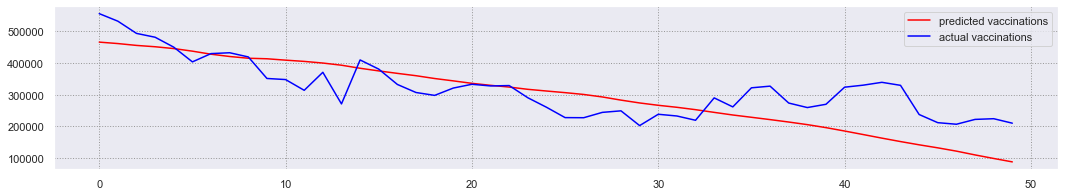

In [497]:
plt.plot(predicted_vaccination, color='red', label='predicted vaccinations')
plt.plot(y_scaler.inverse_transform(y_test.reshape(-1,1)), color='blue', label='actual vaccinations')
plt.legend()

In [ ]:
mean_squared_error(y_test, model.predict(X_test))

0.017149470933304344

In [ ]:
model.save('lstm-time-series.h5')

#### Support Vector Regression

In [498]:
# import Support Vector Regression
from sklearn.svm import SVR

X_scaler_svr = MinMaxScaler()
y_scaler_svr = MinMaxScaler()
X_svr = X_scaler_svr.fit_transform(filtered.iloc[:,:-1])
y_svr = y_scaler_svr.fit_transform(filtered.iloc[:,-1].values.reshape(-1,1))

X_train, X_test, y_train, y_test = train_test_split(X_svr, y_svr, test_size=0.15, random_state=42, shuffle=True)

svr = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr.fit(X_train, y_train)

# mean squared error
print('MSE:', mean_squared_error(y_test, svr.predict(X_test)))

MSE: 0.0065747942495954425


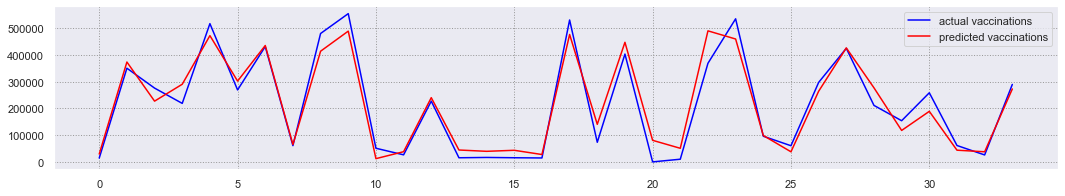

In [501]:
plt.plot(y_scaler_svr.inverse_transform(y_test.reshape(-1,1)), color='blue')
plt.plot(y_scaler_svr.inverse_transform(svr.predict(X_test).reshape(-1,1)), color='red')

#### Linear Regression

In [508]:
# import LinearRegression
from sklearn.linear_model import LinearRegression

X_scaler_svr = MinMaxScaler()
y_scaler_svr = MinMaxScaler()
X_svr = X_scaler_svr.fit_transform(filtered.iloc[:,:-1])
y_svr = y_scaler_svr.fit_transform(filtered.iloc[:,-1].values.reshape(-1,1))

X_train, X_test, y_train, y_test = train_test_split(X_svr, y_svr, test_size=0.15, random_state=42, shuffle=True)

lr = LinearRegression()
lr.fit(X_train, y_train)

# mean squared error
print('MSE:', mean_squared_error(y_test, lr.predict(X_test)))

MSE: 0.016951494664878913


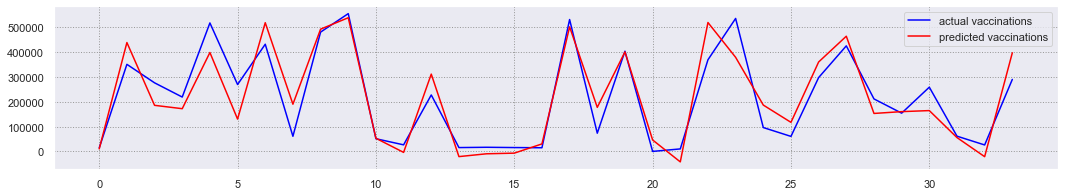

In [503]:
plt.plot(y_scaler_svr.inverse_transform(y_test.reshape(-1,1)), color='blue', label='actual vaccinations')
plt.plot(y_scaler_svr.inverse_transform(lr.predict(X_test).reshape(-1,1)), color='red', label='predicted vaccinations')
plt.legend()

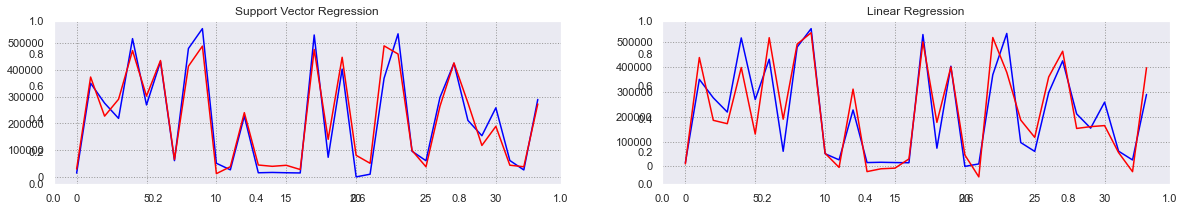

In [511]:
# 3 subplots
fig, axs = plt.subplots(1, 2, figsize=(20,3))
# lstm = fig.add_subplot(131, title='LSTM')
# lstm.plot(predicted_vaccination, color='red', label='predicted vaccinations')
# lstm.plot(y_scaler.inverse_transform(y_test.reshape(-1,1)), color='blue', label='actual vaccinations')

support_vector = fig.add_subplot(121, title='Support Vector Regression')
support_vector.plot(y_scaler_svr.inverse_transform(y_test.reshape(-1,1)), color='blue', label='actual vaccinations')
support_vector.plot(y_scaler_svr.inverse_transform(svr.predict(X_test).reshape(-1,1)), color='red', label='predicted vaccinations')

linear = fig.add_subplot(122, title='Linear Regression')
linear.plot(y_scaler_svr.inverse_transform(y_test.reshape(-1,1)), color='blue', label='actual vaccinations')
linear.plot(y_scaler_svr.inverse_transform(lr.predict(X_test).reshape(-1,1)), color='red', label='predicted vaccinations')

Linear Regression and Support Vector Regression does a very good job in this case, beyond that of the multivariate LSTM. This is maybe due to a small dataset, that is insufficient for proper time-series forecasting.

### Does the current vaccination rate allow herd immunity to be achieved by 30 November 2021? 

To answer this question, we use ARIMA forecasting (Auto-Regressive Integrated Moving Average) to predict the future. A problem is that ARIMA is univariate in nature, so we have to acknowledge that the estimates are quite rough.

In [526]:
vax_malaysia['cumul_full'] = vax_malaysia['daily_full'].cumsum()

In [585]:
from pmdarima import auto_arima

stepwise_fit = auto_arima(vax_malaysia['cumul_full'], start_p=1, start_q=1,
                            max_p=3, max_q=3, m=12,
                            start_P=0, seasonal=False,
                            d=1, D=1, trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5166.004, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5859.863, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5179.570, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5715.171, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6007.510, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5167.775, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5167.537, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5675.693, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5167.355, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5169.513, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5165.227, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5858.010, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5179.805, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=5165.739, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  228
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2579.614
Date:                Sun, 31 Oct 2021   AIC                           5165.227
Time:                        17:21:01   BIC                           5175.502
Sample:                             0   HQIC                          5169.374
                                - 228                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9947      0.005    188.399      0.000       0.984       1.005
ma.L1         -0.2972      0.049     -6.098      0.000      -0.393      -0.202
sigma2      4.449e+08   1.94e-11    2.3e+19      0.000    4.45e+08    4.45e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                45.70
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):              31.19   Skew:                             0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.31e+35. Standard errors may be unstable.
"""

In [586]:
train = vax_malaysia[:len(vax_malaysia) - 50]
test = vax_malaysia[len(vax_malaysia) - 50:]

from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train['cumul_full'], order=(1, 1, 1))
result = model.fit()
result.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.34213D+01    |proj g|=  7.68117D+01

At iterate    5    f=  1.16830D+01    |proj g|=  4.35110D-01

At iterate   10    f=  1.12971D+01    |proj g|=  2.32647D-02

At iterate   15    f=  1.12616D+01    |proj g|=  2.03396D-02

At iterate   20    f=  1.12553D+01    |proj g|=  1.68434D-03

At iterate   25    f=  1.12544D+01    |proj g|=  3.78269D-04

At iterate   30    f=  1.12542D+01    |proj g|=  4.56897D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             cumul_full   No. Observations:                  178
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2003.245
Date:                Sun, 31 Oct 2021   AIC                           4012.489
Time:                        17:21:14   BIC                           4022.017
Sample:                             0   HQIC                          4016.353
                                - 178                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.006    173.427      0.000       0.989       1.011
ma.L1         -0.3343      0.052     -6.378      0.000      -0.437      -0.232
sigma2       4.03e+08   3.02e-11   1.34e+19      0.000    4.03e+08    4.03e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                48.19
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):              53.61   Skew:                             0.68
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.1e+35. Standard errors may be unstable.
"""

<AxesSubplot:>

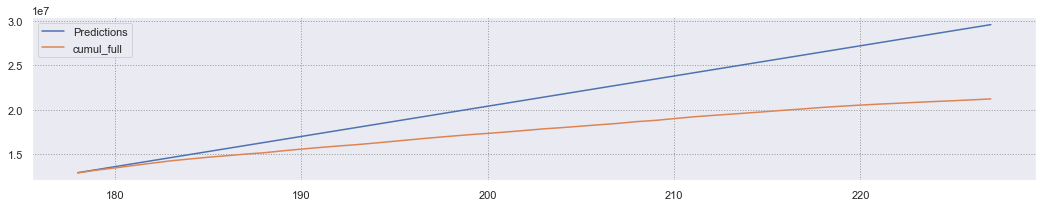

In [587]:
start = len(train)
end = len(train) + len(test) - 1
predictions = result.predict(start, end, typ='levels').rename('Predictions')

predictions.plot(legend=True)
test['cumul_full'].plot(legend=True)

In [588]:
mean_squared_error(test['cumul_full'], predictions)

19596002540455.477

The trained model is not very optimal, only an approximation can be made.

In [576]:
start = 228
end = 288
predictions = result.predict(start, end, typ='levels').rename('Predictions')

In [577]:
cumul_vaccine = list(vax_malaysia['cumul_full'])
cumul_vaccine += predictions.tolist()

In [578]:
vax_malaysia.tail()

,date,daily_partial,daily_full,daily,daily_full_child,cumul,daily_adults,cumul_full,percentage_vaccinated
223,2021-10-05,122153,101881,224034,6278,20819254,95603,20819254,0.637505
224,2021-10-06,113441,96466,209907,8750,20915720,87716,20915720,0.640459
225,2021-10-07,108092,88555,196647,18786,21004275,69769,21004275,0.643170
226,2021-10-08,74199,100621,174820,29091,21104896,71530,21104896,0.646252
227,2021-10-09,39183,102714,141897,27507,21207610,75207,21207610,0.649397


In [579]:
from datetime import date, timedelta
def add_date(dt, row):
    split = dt.split('-')
    year = int(split[0])
    month = int(split[1])
    day = int(split[2])
    date_orig = date(year, month, day)
    new_date = date_orig + timedelta(days=row)
    return str(new_date)
dts = [add_date('2021-10-09', i) for i in range(1, 62)]
dts = list(vax_malaysia['date']) + dts

In [580]:
dts[-50:]

['2021-10-21',
 '2021-10-22',
 '2021-10-23',
 '2021-10-24',
 '2021-10-25',
 '2021-10-26',
 '2021-10-27',
 '2021-10-28',
 '2021-10-29',
 '2021-10-30',
 '2021-10-31',
 '2021-11-01',
 '2021-11-02',
 '2021-11-03',
 '2021-11-04',
 '2021-11-05',
 '2021-11-06',
 '2021-11-07',
 '2021-11-08',
 '2021-11-09',
 '2021-11-10',
 '2021-11-11',
 '2021-11-12',
 '2021-11-13',
 '2021-11-14',
 '2021-11-15',
 '2021-11-16',
 '2021-11-17',
 '2021-11-18',
 '2021-11-19',
 '2021-11-20',
 '2021-11-21',
 '2021-11-22',
 '2021-11-23',
 '2021-11-24',
 '2021-11-25',
 '2021-11-26',
 '2021-11-27',
 '2021-11-28',
 '2021-11-29',
 '2021-11-30',
 '2021-12-01',
 '2021-12-02',
 '2021-12-03',
 '2021-12-04',
 '2021-12-05',
 '2021-12-06',
 '2021-12-07',
 '2021-12-08',
 '2021-12-09']

Plot the extrapolated cumulative vaccination numbers.

In [581]:
len(cumul_vaccine)

289

In [582]:
len(dts)

289

In [583]:
malaysia_population = population[population['state']=='Malaysia']['pop'].values[0]

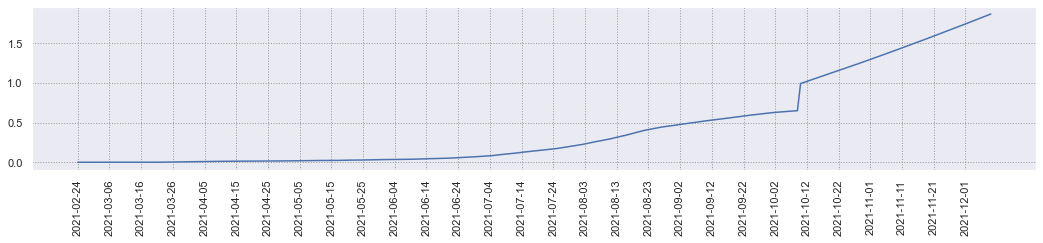

In [584]:
sns.lineplot(dts, (cumul_vaccine / malaysia_population))
plt.xticks([date for i, date in enumerate(dts) if i % 10 == 0], rotation=90)
plt.show()

Based on ARIMA auto-regressive prediction, it is possible that herd immunity will be reached before 30 November, if it continues at this rate.

### Can we predict Covid-19 mortality numbers across the nation?

In [412]:
dataset1 = before_pp_cases_malaysia.copy()
dataset2 = before_pp_deaths_malaysia.copy()
dataset2 = dataset2[['date','deaths_new']]
dataset3 = before_pp_tests_malaysia.copy()
dataset4 = before_pp_vax_malaysia.copy()
total_dataset = dataset1.merge(dataset2, how='inner', on=['date'] )
total_dataset.fillna(0, inplace=True)
total_dataset = total_dataset.merge(dataset3, how='inner', on=['date'] )
total_dataset.fillna(0, inplace=True)
total_dataset = total_dataset.merge(dataset4, how='inner', on=['date'] )
total_dataset.fillna(0, inplace=True)
total_dataset

,date,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_pvax,cases_fvax,cases_child,cases_adolescent,...,cumul_partial_child,cumul_full_child,pfizer1,pfizer2,sinovac1,sinovac2,astra1,astra2,cansino,pending
0,2021-02-24,3545,1,3331,30572,2483.0,0.0,0.0,145.0,84.0,...,0,0,60,0,0,0,0,0,0,0
1,2021-02-25,1924,6,3752,28738,705.0,0.0,0.0,158.0,72.0,...,0,0,1146,0,0,0,0,0,0,0
2,2021-02-26,2253,7,3085,27903,1136.0,0.0,0.0,124.0,75.0,...,0,0,4115,1,0,0,0,0,0,0
3,2021-02-27,2364,1,3320,26937,1100.0,0.0,0.0,147.0,100.0,...,0,0,6723,1,0,0,0,0,0,0
4,2021-02-28,2437,1,3251,26118,1404.0,0.0,0.0,132.0,83.0,...,0,0,6699,3,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,2021-10-02,10915,7,15396,155499,656.0,1306.0,5885.0,1951.0,938.0,...,1666131,92949,85634,73484,1907,13712,116,32558,1644,2462
221,2021-10-03,9066,12,14454,150019,388.0,1124.0,4944.0,1700.0,764.0,...,1751834,108826,87792,66883,1907,9508,18,33146,682,6638
222,2021-10-04,8075,6,15456,142562,731.0,1097.0,4287.0,1353.0,641.0,...,1862399,114124,123351,58454,2620,8339,144,26749,1348,807
223,2021-10-05,8817,14,15615,135685,619.0,1062.0,5106.0,1386.0,686.0,...,1967549,120402,119323,59655,2440,13395,130,26496,1828,767


In [415]:
X = total_dataset.drop(['date','deaths_new'], axis=1)
y = total_dataset['deaths_new']  

rf = RandomForestRegressor(n_jobs=4, oob_score=True)
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=0)
boruta.fit(X_scaled, y.ravel())
boruta_best = [X.columns[i] for i, x in enumerate(boruta.support_) if x]

print(boruta_best)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	38
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	38
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	38
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	38
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	38
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	38
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	38
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	9
Tentative: 	9
Rejected: 	20
Iteration: 	9 / 100
Confirmed: 	9
Tentative: 	9
Rejected: 	20
Iteration: 	10 / 100
Confirmed: 	9
Tentative: 	9
Rejected: 	20
Iteration: 	11 / 100
Confirmed: 	9
Tentative: 	9
Rejected: 	20
Iteration: 	12 / 100
Confirmed: 	9
Tentative: 	9
Rejected: 	20
Iteration: 	13 / 100
Confirmed: 	9
Tentative: 	9
Rejected: 	20
Iteration: 	14 / 100
Confirmed: 	9
Tentative: 	9
Rejected: 	20
Iteration: 	15 / 100
Confirmed: 	9
Tentative: 	9
Rejected: 	20
Iteration: 	16 / 100
Confirmed: 	10
Tentative: 	7
Rejected: 	21


In [414]:
train_model_dataset = total_dataset[boruta_best]
train_model_dataset['deaths_new'] = total_dataset['deaths_new']

In [261]:
X = train_model_dataset.drop(['deaths_new'], axis=1)  
X = MinMaxScaler().fit_transform(X)
y = train_model_dataset['deaths_new']  
y = MinMaxScaler().fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=2) 

In [262]:
regressor = DecisionTreeRegressor(max_depth=2, criterion="mae", splitter="best")  
regressor.fit(X_train, y_train) 
pred = regressor.predict(X_test)

In [263]:
mae = round(mean_absolute_error(y_test, pred),4)
mse = round(mean_squared_error(y_test, pred),4)

print('DecisionTreeRegressor MAE: ', mae)
print('DecisionTreeRegressor MSE: ', mse)

DecisionTreeRegressor MAE:  0.057
DecisionTreeRegressor MSE:  0.0123


First of all, we perform feature selection from cases_malaysia.csv, deaths_malaysia.csv, and tests_malaysia.csv datasets by using Boruta in python. After that , the  features that are being selected will be used to train our decision tree regressor model. For our model, it is able to archieve a 0.057 mean absolute error and a 0.0123 mean squared error.

### Can we predict mortality numbers for Melaka, Negeri Sembilan, Perlis, Selangor and W.P. Putrajaya?

In [264]:
def state_mortality_prediction(state) :
    dataset1 = before_pp_cases_state.copy()
    dataset2 = before_pp_deaths_state.copy()
    dataset2 = dataset2[['date','state','deaths_new']]
    dataset3 = before_pp_tests_state.copy()
    dataset4 = before_pp_vax_state.copy()
    total_dataset = dataset1[dataset1['state'] == state].merge(dataset2[dataset2['state'] == state], how='inner', on=['date','state'] )
    total_dataset.fillna(0, inplace=True)
    total_dataset = total_dataset.merge(dataset3[dataset3['state'] == state], how='inner', on=['date','state'] )
    total_dataset.fillna(0, inplace=True)
    total_dataset = total_dataset.merge(dataset4[dataset4['state'] == state], how='inner', on=['date','state'] )
    total_dataset.fillna(0, inplace=True)
    X = total_dataset.drop(['date','deaths_new','state'], axis=1)  
    y = total_dataset['deaths_new']  


    rfe_selector = RFE(LinearRegression(), n_features_to_select=10)
    rfe_selector.fit(X, y)
    rfe_best = X.columns[rfe_selector.get_support()]
    print (rfe_best)


    return rfe_best,total_dataset

In [265]:
def get_result(rfe_best , total_dataset) :
    train_model_dataset = total_dataset[rfe_best]
    train_model_dataset['deaths_new'] = total_dataset['deaths_new']
    X = train_model_dataset.drop(['deaths_new'], axis=1)  
    X = MinMaxScaler().fit_transform(X)
    y = train_model_dataset['deaths_new']  
    y = MinMaxScaler().fit_transform(y.values.reshape(-1, 1))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=2) 
    regressor = DecisionTreeRegressor(max_depth=2, criterion="mae", splitter="best")  
    regressor.fit(X_train, y_train) 
    pred = regressor.predict(X_test)
    mae = round(mean_absolute_error(y_test, pred),4)
    mse = round(mean_squared_error(y_test, pred),4)

    print('DecisionTreeRegressor MAE: ', mae)
    print('DecisionTreeRegressor MSE: ', mse)

In [266]:
rfe_best_Melaka , total_dataset_Melaka = state_mortality_prediction('Melaka')

Index(['cases_new', 'cases_import', 'cases_cluster', 'cases_child',
       'cases_adolescent', 'cases_adult', 'cases_elderly', 'cumul_partial',
       'cumul', 'cumul_full_child'],
      dtype='object')


In [267]:
rfe_best_Negeri_Sembilan , total_dataset_Negeri_Sembilan = state_mortality_prediction('Negeri Sembilan')

Index(['cases_new', 'cases_import', 'cases_cluster', 'cases_pvax',
       'cases_child', 'cases_adult', 'cases_elderly', 'daily_full_child',
       'cumul_full_child', 'pending'],
      dtype='object')


In [268]:
rfe_best_Perlis , total_dataset_Perlis = state_mortality_prediction('Perlis')

Index(['cases_new', 'cases_recovered', 'cases_fvax', 'cases_child',
       'cases_adolescent', 'cases_adult', 'cases_elderly', 'cumul_full_child',
       'astra2', 'pending'],
      dtype='object')


In [269]:
rfe_best_Selangor , total_dataset_Selangor = state_mortality_prediction('Selangor')

Index(['cases_new', 'cases_import', 'cases_fvax', 'cases_child', 'cases_adult',
       'cases_elderly', 'cumul_partial', 'cumul_full', 'cumul', 'cansino'],
      dtype='object')


In [270]:
rfe_best_WP_Putrajaya , total_dataset_WP_Putrajaya = state_mortality_prediction('W.P. Putrajaya')

Index(['cases_new', 'cases_import', 'cases_cluster', 'cases_child',
       'cases_adolescent', 'cases_elderly', 'daily_partial',
       'daily_full_child', 'pfizer1', 'sinovac1'],
      dtype='object')


In [271]:
print("Melaka")
get_result(rfe_best_Melaka , total_dataset_Melaka)
print("")
print("Negeri Sembilan")
get_result(rfe_best_Negeri_Sembilan , total_dataset_Negeri_Sembilan)
print("")
print("Perlis")
get_result(rfe_best_Perlis , total_dataset_Perlis)
print("")
print("Selangor")
get_result(rfe_best_Selangor , total_dataset_Selangor)
print("")
print("W.P. Putrajaya")
get_result(rfe_best_WP_Putrajaya , total_dataset_WP_Putrajaya)
print("")

Melaka
DecisionTreeRegressor MAE:  0.1051
DecisionTreeRegressor MSE:  0.0167

Negeri Sembilan
DecisionTreeRegressor MAE:  0.1333
DecisionTreeRegressor MSE:  0.0258

Perlis
DecisionTreeRegressor MAE:  0.15
DecisionTreeRegressor MSE:  0.0792

Selangor
DecisionTreeRegressor MAE:  0.0548
DecisionTreeRegressor MSE:  0.0067

W.P. Putrajaya
DecisionTreeRegressor MAE:  0.0333
DecisionTreeRegressor MSE:  0.0167



For these questions, we used Recursive Feature Elimination(RFE) for the features selection part and the datasets involved are cases_state.csv, deaths_state.csv, tests_state.csv, and vax_state.csv. After the features are selected, we will use the features in our decision tree regressor model to perform the prediction. Based on our results, W.P. Putrajaya scored the lowest value in the mean absolute error which is only 0.0333 and Selangor scored the lowest value in the mean squared error result,0.0067.

## Classification
There are two main classification problems we intend to solve: classifying whether the checkins for the day will be high, medium or low and predicting the vaccine type based on the reported symptoms. 

Hyperparameter tuning is done using GridSearchCV.

### Can we classify individual location check-ins in Malaysia using other variables (Low, Medium or High)?
We first do feature selection using Boruta, SMOTE the dataset, then evaluate the Random Forest Classifier, Logistic Regression and the Naive Bayes classifier.

<AxesSubplot:>

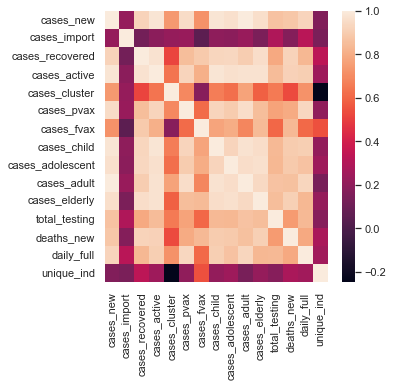

In [383]:
cases_testing_deaths_vax_checkins = cases_malaysia.merge(tests_malaysia, on='date')
cases_testing_deaths_vax_checkins = cases_testing_deaths_vax_checkins.merge(deaths_malaysia, on='date')
cases_testing_deaths_vax_checkins = cases_testing_deaths_vax_checkins.merge(vax_malaysia[['date', 'daily_full']], on='date')
cases_testing_deaths_vax_checkins = cases_testing_deaths_vax_checkins.merge(checkins[['date', 'unique_ind']], on='date')
plt.figure(figsize=(5,5))
sns.heatmap(cases_testing_deaths_vax_checkins.corr())

Discretize the values based on the statistical distribution.

In [385]:
cases_testing_deaths_vax_checkins['unique_ind'].max()
cases_testing_deaths_vax_checkins['ind_checkins_class'] = pd.cut(cases_testing_deaths_vax_checkins['unique_ind'], 3, labels=['Low', 'Medium', 'High'])
cases_testing_deaths_vax_checkins.drop(['unique_ind'], axis=1, inplace=True)

In [388]:
X_scaler = MinMaxScaler()

In [392]:
from sklearn.ensemble import RandomForestClassifier

X = cases_testing_deaths_vax_checkins.drop(columns=['date', 'ind_checkins_class'])
X_scaled = X_scaler.fit_transform(X)
y = cases_testing_deaths_vax_checkins['ind_checkins_class']

rf = RandomForestClassifier(n_jobs=-1, max_depth=5)

feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)

feat_selector.fit(X_scaled, y.ravel())

feat_selector.support_

feat_selector.ranking_

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	0
Iteration: 	10 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	0
Iteration: 	11 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	0
Iteration: 	12 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	0
Iteration: 	13 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	0
Iteration: 	14 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	0
Iteration: 	15 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	0
Iteration: 	16 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	0
I

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [393]:
# chosen features
accept = X.columns[feat_selector.support_].to_list()
# transform dataframe to only selected features
filtered = pd.DataFrame(feat_selector.transform(X_scaled), columns=accept)
# add back date and percentage vaccinated
filtered['ind_checkins_class'] = y
filtered['date'] = cases_testing_deaths_vax_checkins['date']
filtered['date'] = pd.to_datetime(filtered['date'])
filtered.set_index('date', inplace=True)
filtered

,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_pvax,cases_fvax,cases_child,cases_adolescent,cases_adult,cases_elderly,total_testing,deaths_new,daily_full,ind_checkins_class
date,,,,,,,,,,,,,,,
2021-02-24,0.110068,0.015625,0.095744,0.066213,0.701214,0.000000,0.000000,0.008992,0.031440,0.140542,0.061571,0.277715,0.018613,0.000000,Medium
2021-02-25,0.041550,0.093750,0.113431,0.058875,0.118071,0.000000,0.000000,0.011283,0.024821,0.048627,0.052017,0.351273,0.020305,0.000000,Medium
2021-02-26,0.055457,0.109375,0.085409,0.055533,0.259429,0.000000,0.000000,0.005289,0.026475,0.070811,0.061571,0.312421,0.015228,0.000003,Medium
2021-02-27,0.060149,0.015625,0.095282,0.051668,0.247622,0.000000,0.000000,0.009344,0.040265,0.073099,0.055732,0.199065,0.015228,0.000003,Medium
2021-02-28,0.063234,0.015625,0.092383,0.048391,0.347327,0.000000,0.000000,0.006700,0.030888,0.084922,0.029724,0.171559,0.013536,0.000008,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-02,0.421591,0.109375,0.602613,0.566113,0.102001,0.179150,0.702016,0.327398,0.502482,0.384439,0.588641,0.461996,0.182741,0.337830,High
2021-10-03,0.343436,0.187500,0.563038,0.544185,0.014103,0.154184,0.589765,0.283145,0.406509,0.294940,0.546709,0.429835,0.197970,0.306571,High
2021-10-04,0.301547,0.093750,0.605134,0.514346,0.126599,0.150480,0.511392,0.221968,0.338665,0.275998,0.472930,0.966934,0.126904,0.264499,High


In [394]:
from imblearn.over_sampling import SMOTE
# import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
# SMOTE dataset
X = filtered.drop(columns=['ind_checkins_class'])
y = filtered['ind_checkins_class']
smt = SMOTE(random_state=42, k_neighbors=3)
X_smt, y_smt = smt.fit_resample(X, y)

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_smt, y_smt, test_size=0.2, random_state=42)

#### Random Forest Classifier

Accuracy of Random Forest:  0.9310344827586207
F1-Score of Random Forest:  0.9315942678011644


<AxesSubplot:>

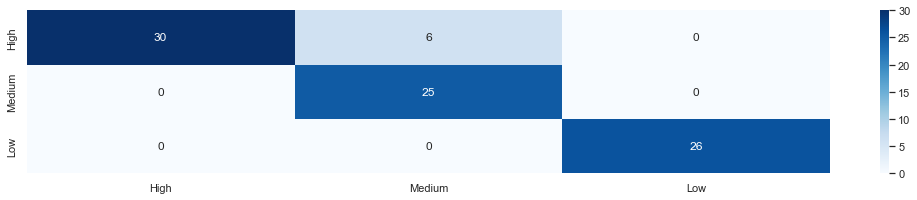

In [395]:
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
rf.fit(X_train, y_train)
# get score
accuracy = rf.score(X_test, y_test)
# F1-Score
f1 = f1_score(y_test, rf.predict(X_test), average='weighted')

print('Accuracy of Random Forest: ', accuracy)
print('F1-Score of Random Forest: ', f1)

y_pred = rf.predict(X_test)

labels = ['High', 'Medium', 'Low']
sns.heatmap(confusion_matrix(y_test, y_pred, labels=['High', 'Medium', 'Low']), fmt='', cmap='Blues', xticklabels=labels, yticklabels=labels, annot=True)

In [396]:
confusion_matrix(y_test, y_pred, labels=['High', 'Medium', 'Low'])

array([[30,  6,  0],
       [ 0, 25,  0],
       [ 0,  0, 26]])

#### Logistic Regression

Accuracy of Logistic Regression:  0.7701149425287356
F1-Score of Logistic Regression:  0.7682276595193018


<AxesSubplot:>

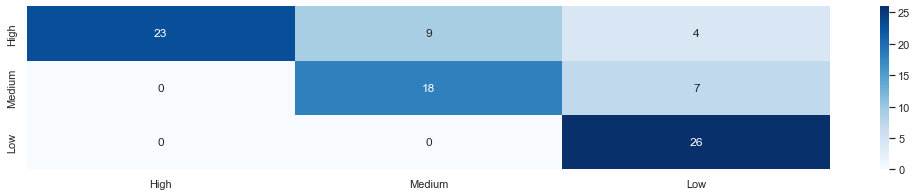

In [397]:
from sklearn.linear_model import LogisticRegression

log = LogisticRegression()
log.fit(X_train, y_train)
accuracy = log.score(X_test, y_test)
f1 = f1_score(y_test, log.predict(X_test), average='weighted')

print('Accuracy of Logistic Regression: ', accuracy)
print('F1-Score of Logistic Regression: ', f1)

y_pred = log.predict(X_test)

labels = ['High', 'Medium', 'Low']
sns.heatmap(confusion_matrix(y_test, y_pred, labels=['High', 'Medium', 'Low']), fmt='', cmap='Blues', xticklabels=labels, yticklabels=labels, annot=True)

#### Naive Bayes Classifier

Accuracy of Naive Bayes:  0.6091954022988506
F1-Score of Naive Bayes:  0.5943829569445332


<AxesSubplot:>

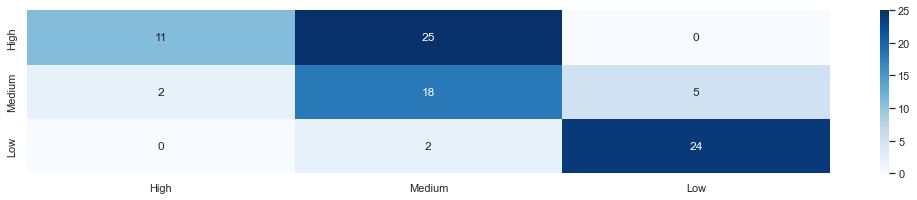

In [398]:
# import naive bayes classifier
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)

accuracy = gnb.score(X_test, y_test)
f1 = f1_score(y_test, gnb.predict(X_test), average='weighted')

print('Accuracy of Naive Bayes: ', accuracy)
print('F1-Score of Naive Bayes: ', f1)

y_pred = gnb.predict(X_test)

labels = ['High', 'Medium', 'Low']
sns.heatmap(confusion_matrix(y_test, y_pred, labels=['High', 'Medium', 'Low']), fmt='', cmap='Blues', xticklabels=labels, yticklabels=labels, annot=True)

The Random Forest Classifier performs best in this case.

### Can we predict the type of vaccine based on the symptoms?

We use self-reported symptoms for each vaccine daily as the training data. Appropriate hyperparameter tuning is done using GridSearchCV for the Random Forest Classifier. Both Logistic Regression and the Support Vector Classifier are evaluated for this question using the metrics accuracy and weighted averaged F1-Score. The training set is SMOTE-d.

Feature selection (symptoms) is done using Recursive Feature Elimination.

In [399]:
# import labelencoder
from sklearn.preprocessing import LabelEncoder

In [400]:
vaccine_prediction = aefi.copy()
vaccine_prediction['vaxtype_label'] = LabelEncoder().fit_transform(vaccine_prediction['vaxtype'])
vaccine_prediction['vaxtype_label'].value_counts()

2    217
3    184
0    148
1     33
Name: vaxtype_label, dtype: int64

In [401]:
vaccine_prediction.drop(columns=['daily_total'], inplace=True)

In [451]:
# recursive feature elimination
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

X_scaler = MinMaxScaler()
X = vaccine_prediction.drop(columns=['date', 'vaxtype', 'vaxtype_label'])
X_scaled = X_scaler.fit_transform(X)
y = vaccine_prediction['vaxtype_label']

logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(X_scaled, y)

X_transformed = pd.DataFrame(rfe.transform(X_scaled), columns=X.columns[rfe.support_])
X_transformed

,daily_nonserious_mysj,daily_nonserious_npra,daily_serious_npra,daily_nonserious_mysj_dose1,d1_site_pain,d1_site_swelling,d1_site_redness,d1_headache,d1_muscle_pain,d1_joint_pain,d1_weakness,d1_fever,d1_chills,d1_rash,d2_site_pain,d2_site_swelling,d2_headache,d2_joint_pain,d2_fever,d2_chills
0,0.000000,0.002674,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.005348,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.010695,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.029412,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.077540,0.190476,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,0.018579,0.016043,0.000000,0.016913,0.009338,0.003386,0.008630,0.012688,0.008643,0.009459,0.012541,0.005889,0.005395,0.060870,0.007418,0.007353,0.005891,0.011278,0.018519,0.005025
578,0.148632,0.000000,0.047619,0.146879,0.135249,0.071633,0.072276,0.157227,0.142490,0.178041,0.149615,0.148623,0.142857,0.186957,0.011869,0.014706,0.016200,0.026316,0.041667,0.035176
579,0.242202,0.216578,0.380952,0.227809,0.226583,0.108622,0.111111,0.141412,0.122635,0.094257,0.114631,0.049887,0.046828,0.321739,0.066766,0.051471,0.106038,0.109023,0.148148,0.105528
580,0.000000,0.002674,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [452]:
X_transformed.columns

Index(['daily_nonserious_mysj', 'daily_nonserious_npra', 'daily_serious_npra',
       'daily_nonserious_mysj_dose1', 'd1_site_pain', 'd1_site_swelling',
       'd1_site_redness', 'd1_headache', 'd1_muscle_pain', 'd1_joint_pain',
       'd1_weakness', 'd1_fever', 'd1_chills', 'd1_rash', 'd2_site_pain',
       'd2_site_swelling', 'd2_headache', 'd2_joint_pain', 'd2_fever',
       'd2_chills'],
      dtype='object')

In [453]:
# X_scaler = StandardScaler()
# X_scaled = X_scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

In [454]:
from imblearn.over_sampling import SMOTE
# import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
# SMOTE dataset

smt = SMOTE(random_state=42, k_neighbors=3)
X_smt, y_smt = smt.fit_resample(X_train, y_train)

### Logistic Regression

In [455]:
# import f1_score
from sklearn.metrics import f1_score

logreg = LogisticRegression()
logreg.fit(X_smt, y_smt)

# Accuracy
accuracy = logreg.score(X_test, y_test)
# F1 score
f1 = f1_score(y_test, logreg.predict(X_test), average='weighted')

print('Accuracy of Logistic Regression: ', accuracy)
print('F1-Score of Logistic Regression: ', f1)

Accuracy of Logistic Regression:  0.6923076923076923
F1-Score of Logistic Regression:  0.7486594986594987


### Support Vector Classification with GridSearchCV hyperparameter tuning

In [456]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear', 'rbf']}
 
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
 
# fitting the model for grid search
grid.fit(X_smt, y_smt)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.566 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.545 total time=   0.0s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.535 total time=   0.0s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.528 total time=   0.0s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.563 total time=   0.0s
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.622 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.566 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.570 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.570 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.592 total time=   0.0s
[CV 1/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.566 total time=   0.0s
[CV 2/5] END ...C=0.1, gamma=0.1, kernel=linear

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['linear', 'rbf']},
             verbose=3)

In [457]:
grid.best_estimator_.get_params()

{'C': 1000,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 1,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [458]:
svc = SVC(**{'C': 1000, 'gamma': 1, 'kernel': 'rbf'})
svc.fit(X_smt, y_smt)

grid.best_params_

{'C': 1000, 'gamma': 1, 'kernel': 'rbf'}

In [459]:
# import f1_score
from sklearn.metrics import f1_score
# import supportvectorclassifier

# get best model
# svc = grid.best_estimator_

# Accuracy
accuracy = svc.score(X_test, y_test)
# F1 score
f1 = f1_score(y_test, svc.predict(X_test), average='weighted')

print('Accuracy of Support Vector Classification: ', accuracy)
print('F1-Score of Support Vector Classification: ', f1)

Accuracy of Support Vector Classification:  0.9230769230769231
F1-Score of Support Vector Classification:  0.9289592760180996


Logistic Regression performs better than Support Vector Classification in this case with both a superior accuracy and weighted F1-Score.

## Conclusion

<img src="./covid-19.jpeg" width=300>

We have reached the end of this exploration. Covid-19 has taken Malaysia by storm and the situation is rapidly changing. Some trends are more noticeable than others, and meaningful outliers are prevalent across most Covid statistics. 